# Paper IEEE Access (Quali) - Análises Adicionais (SVM)

Objetivo: ampliar os resultados da submissão pro IEEE PES GM2021, a partir dos comentários recebidos dos revisores, extraindo as seguintes métricas:

- Avaliar DLAFE  treinado na casa 3 quando aplicada nas demais casas similares , para cada um dos aparelhos -> (objetivo: checar generalização "superficial" - sem retreino do extrator/classificador)
- Avaliar desempenho em aparelhos complexos, baseado em 3 categorias: longo tempo de transitório de ativação / alta flutuação de operação / aparelhos com sobreposição de transitórios (INVIÁVEL POR EQTO)
- Avaliar o impacto da janela para cada aparelho, de acordo c seu modo de operação (especialmente dishwasher)

E se der tempo...
- Fine-tuning do extrator + classificador

**Observações adicionais**:
* Taxa fixada em 2s;
* Avaliar execuções adicionais com classificador SVM.


# Configurações

In [1]:
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from six import iteritems

%matplotlib inline

In [2]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *

from pretty_confusion_matrix import *

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

# Dados

In [3]:
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

## Base REDD

In [4]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS
RESIDENCIA = 3

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "25", "SVM") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

In [5]:
# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    from nilmtk.dataset_converters import convert_redd
    
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
# Exemplo de carregamento da base REDD no NILMTK
import h5py # * Evitar erro de incompatibilidade entre h5py e nilmtk
from nilmtk import DataSet
from nilmtk.utils import print_dict
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)
print()


NILMTK -> Detalhes sobre o dataset REDD:


## Ambiente e Funções Auxiliares

In [6]:
# from PyNILM.dados.janelas import Janelas
from PyNILM.dados.janelas import Janelas
from PyNILM.dados.utils import *

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from PyNILM.modelos.utils import *
from PyNILM.modelos.dlafe import DLAFE

# Inicializar uso GPU
start_tf_session(memory_limit=int(1024*4))

Virtual devices cannot be modified after being initialized


## Configurações do Experimento

In [7]:
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Parametros dos dados
PARAMETROS_DATASET_GERAL = {
    "base":redd,
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-04-16', # 01:11:27',
    "fim_intervalo": '2011-05-30',    # 20:19:54',
    "debug": False    
}

# Dados de treino
PARAMETROS_DATASET_TREINO = {
    "base":redd,
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-04-16', #, # MUDANCA
    "fim_intervalo": '2011-05-16', #'2011-05-30 20:19:54', #,
    "debug": False    
}

# Dados de teste
PARAMETROS_DATASET_TESTE = {
    "base":redd,
    "id_residencia": RESIDENCIA,
    "inicio_intervalo": '2011-05-17', #, # MUDANCA
    "fim_intervalo": '2011-05-30', #'2011-05-30 20:19:54', #,
    "debug": False    
}

# Teste da classe
janelas_treino = Janelas(
    base=DataSet(arquivo_dataset),
    id_residencia=3,
    inicio_intervalo='2011-04-16',
    fim_intervalo='2011-05-16',
    debug = False
)

janelas_teste = Janelas(
    base=DataSet(arquivo_dataset),
    id_residencia=3,
    inicio_intervalo='2011-05-17',
    fim_intervalo='2011-05-30',
    debug = False
)

aparelhos = [
    'dish_washer - 9',
    'fridge - 7',
    'microwave - 16',
    'washer_dryer - 13', 
    'washer_dryer - 14'
]

TAXA = 2 # Fixa
MODELO = SVC(kernel='rbf', random_state=SEED)

## Análise Exploratória

In [ ]:
casa = redd.buildings[3]

fig = plt.figure(figsize=(20,8))
ax = casa.elec.plot()
ax.set_xticks(list(set(next(casa.elec[1].load()).index.map(str).map(lambda x: x.split(' ')[0]))))
plt.title('Full REDD dataset - House #3');
plt.show()

In [ ]:
redd.set_window(
    start=PARAMETROS_DATASET_TREINO["inicio_intervalo"],
    end=PARAMETROS_DATASET_TREINO["fim_intervalo"]
)
casa = redd.buildings[3]

fig = plt.figure(figsize=(20,8))
ax = casa.elec.plot()
ax.set_xticks(list(set(next(casa.elec[1].load()).index.map(str).map(lambda x: x.split(' ')[0]))))
plt.title('Train REDD dataset - House #3');
plt.show()

In [ ]:
redd.set_window(
    start=PARAMETROS_DATASET_TESTE["inicio_intervalo"],
    end=PARAMETROS_DATASET_TESTE["fim_intervalo"]
)
casa = redd.buildings[3]

fig = plt.figure(figsize=(20,8))
ax = casa.elec.plot()
ax.set_xticks(list(set(next(casa.elec[1].load()).index.map(str).map(lambda x: x.split(' ')[0]))))
plt.title('Test REDD dataset - House #3');
plt.show()

In [ ]:


# Tipos de atributos
print("ATRIBUTOS DISPONÍVEIS POR REGISTRO:\n")
for e in casa.elec.all_meters():
    if type(e) == nilmtk.elecmeter.ElecMeter:
        print(f"{e.label()}: {e.available_columns()}")
    else:
        for e_ in e.all_meters():
            print(f" - {e_.label()}: {e_.available_columns()}")

In [ ]:
mains_1 = next(casa.elec[1].load())
mains_1

In [ ]:
mains_2 = next(casa.elec[2].load())
mains_2

In [ ]:
next(casa.elec[1].when_on(on_power_threshold=10)) 

In [ ]:
redd.set_window(
    start=PARAMETROS_DATASET["inicio_intervalo"],
    end=PARAMETROS_DATASET["fim_intervalo"]
)
next(casa.elec[1].when_on(on_power_threshold=10)) 

In [ ]:
# import plotly.express as px


# for e in redd.buildings[3].elec.meters:
#     activations = e.activation_series()
#     if len(activations) > 0:
#         df_activations = pd.concat(activations, axis=1)
#         df_activations.columns = [f'Activation #{a+1}' for a in range(len(activations))]

#         fig = px.line(df_activations, title=f'{e.label()} - {e.instance()}')
#         fig.show()
#     else:
#         fig = plt.figure()
#         e.plot()
#         plt.show()

In [ ]:
from pyts.image import RecurrencePlot

# Parametros RP (verificado empiricamente)
# 
# Taken’s embedding theorem (1980)
D = 5
m = 2#2 * D + 1
t = 1
PARAMETROS_RP = {
    "dimension": m,
    "time_delay": 1,
    "threshold": 'point',
    "percentage": 50
}

activations = redd.buildings[3].elec.meters[16].activation_series()

rps = []
for i,a in enumerate(activations):
    serie_original = a.values
    rp_original = RecurrencePlot(**PARAMETROS_RP).fit_transform([serie_original])[0]
    serie_norm = serie_original / serie_original.max()
    rp_norm = RecurrencePlot(**PARAMETROS_RP).fit_transform([serie_norm])[0]

    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(range(len(serie_original)), serie_original)
    axs[0, 0].set_title('Serie Original')
    axs[0, 1].imshow(rp_original, cmap='binary', origin='lower')
    axs[0, 1].set_title('RP')
    axs[1, 0].plot(range(len(serie_norm)), serie_norm)
    axs[1, 0].set_title('Serie Norm.')
    axs[1, 1].imshow(rp_norm, cmap='binary', origin='lower')
    axs[1, 1].set_title('RP')
    plt.tight_layout()
    plt.suptitle(f'Amostra #{i}')
    fig.show()
    

In [ ]:
del casa

## Melhores Combinações de Taxas e Janelas para cada Aparelho (estudo 19)

In [8]:
df_melhores_taxas_janelas = pd.read_csv(os.path.join(caminho_dados, "19", "melhores_taxa_janela_aparelhos.csv"), index_col=0)
df_melhores_taxas_janelas

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,dish_washer - 9,2,720,0.05,95.33,20.00,25.00,22.22,59.91
1,fridge - 7,2,1080,0.00,100.00,100.00,100.00,100.00,100.00
2,microwave - 16,2,900,0.04,95.83,66.67,33.33,44.44,71.14
3,washer_dryer - 13,2,60,0.00,99.89,100.00,95.74,97.83,98.88
4,washer_dryer - 14,3,360,0.02,97.99,100.00,55.56,71.43,85.19


In [9]:
# TODO: 
# - Desenvolver módulo da metodologia na lib PyNILM

## Parâmetros de RP dos Aparelhos (estudo 18)

In [10]:
# Carregando arquivos de parametros, caso n estejam (kernel reiniciado)
import json
if not 'parametros_rp_aparelho' in locals():
    with open(os.path.join(caminho_dados, "18", "parametros_rp_aparelho.json"),'r') as arquivo:
        parametros_rp_aparelho = json.load(arquivo)

# Resultados Paper IEEE Access - Indicadores Adicionais

In [11]:
# libraries
import seaborn as sns

matplotlib.style.use('default')
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = 'gray'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['grid.alpha'] = .5
sns.set(font_scale=1.3, style=None, palette=None)

## Generalização "superficial" 

Avaliar proposta quando usado para inferência em demais casas (sem retreino).

In [11]:
# Avaliar em cada uma das casas similares ao estudo (3)
# Dishwasher     - Casas 1, 2, 4, 5, 6
# Fridge         - Casas 1, 2,    5, 6
# Microwave      - Casas 1, 2,    5
# Washer Dryer 1 - Casas 1, 2, 4, 5, 6 
# Washer Dryer 2 - Casas 1, 2, 4, 5, 6

resultados_generalizacao = {
    "house": [], "appliance": [], "acc": [], "f1": [], "auc": []}

for RESIDENCIA_TESTE in [1,2,5]:
    
    print("="*80)
    print(f"# AVALIANDO GENERALIZAÇÃO PARCIAL NA CASA #{RESIDENCIA_TESTE}...\n")
    print("="*80)
    print()

    # Dados de teste (inferencia generalizacao)
    janelas_teste = Janelas(**{
        'base': redd,
        'id_residencia': RESIDENCIA_TESTE,
        'inicio_intervalo': PARAMETROS_DATASET_TESTE['inicio_intervalo'],
        'fim_intervalo': PARAMETROS_DATASET_TESTE['fim_intervalo'],
        'debug': False
    })

    for rotulo_aparelho in df_melhores_taxas_janelas.loc[
        df_melhores_taxas_janelas["carga"].isin(
            ['dish_washer - 9','fridge - 7','microwave - 16','washer_dryer - 13',
             'washer_dryer - 14']),
        : ]["carga"].values:

        print(f"* Treinando Modelo p/ Aparelho {rotulo_aparelho.upper()}:\n")

        
        # Informacoes da carga selecionada
        CARGA = rotulo_aparelho.split(" - ")[0]
        INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

        config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==rotulo_aparelho
        ].to_dict("records")[0]
        TAMANHO_JANELA = config_aparelho["janela"]
        CONFIG_RP_APARELHO = PARAMETROS_RP
        

        # Extrair series divididas em janelas para cada medidor
        print("   - Base de TREINO\n")
        print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X_treino, y_treino = carregar_dados_aparelho(
            janelas=janelas_treino, # Resid 3
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print("     -> Detalhes da amostragem (lotes):")
        print("     ---")
        for item in Counter(y_treino).items():
            print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_treino)*100,1)}%)" )
        print()


        # Treinando modelo
        print("     -> Treinando modelo...")
        dlafe = DLAFE(
            feature_extractor = transfer_learning.vgg16.VGG16(
                input_shape=TAMANHO_IMAGEM_DLAFE,
                weights='imagenet', 
                include_top=False,
                pooling='avg'
            ),
            preprocess_input = transfer_learning.vgg16.preprocess_input,
            classifier = clone(MODELO),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X_treino, y_treino)
        print()

        # Percorrer instancias do aparelho na residencia
        print(f"   - Preparando dados de teste (residência alvo)...\n")
        for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA_TESTE, base = redd):
            
            print("   - Base de TESTE\n")

            # Extrair series divididas em janelas para cada medidor
            print("     . Carregando janelas (taxa={:.0f}, janela={:.0f})...".format(
                TAXA, TAMANHO_JANELA
            ))
            X_teste, y_teste = carregar_dados_aparelho(
                janelas=janelas_teste,
                instancia=INSTANCIA,
                aparelho=CARGA,
                tamanho_janela=TAMANHO_JANELA,
                taxa=TAXA,
                eliminar_janelas_vazias=True
            )
            print()

            print("     . Detalhes da amostragem (lotes):")
            print("     ---")
            for item in Counter(y_teste).items():
                print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
            print()

            # Prevendo conjunto de teste
            print("     . Avaliando modelo...")
            y_hat = dlafe.predict(X_teste)

            # Incrementando resultados
            # Incrementando resultados
            acuracia = accuracy_score(y_teste, y_hat)
            f1_macro = f1_score(y_teste, y_hat, average="macro")
            area_curva = roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5
            print("     . Resultados...")
            print(f"        -> Acurácia: {acuracia*100:.2f}%")
            print(f"        -> F1-macro: {f1_macro*100:.2f}%")
            print(f"        -> AUC     : {area_curva}")
            
            resultados_generalizacao["house"].append(RESIDENCIA_TESTE)
            resultados_generalizacao["appliance"].append(f'{CARGA} - {INSTANCIA}')
            resultados_generalizacao["acc"].append( acuracia )
            resultados_generalizacao["f1"].append( f1_macro )
            resultados_generalizacao["auc"].append( area_curva )

            print()
            print("-"*80)
            print()
            
            
# Persistindo resultados
df_generalizacao_superficial = pd.DataFrame(resultados_generalizacao)
df_generalizacao_superficial.to_excel(os.path.join(caminho_dados_notebook, "df_generalizacao_superficial.xlsx"))

print("############################## FINAL MODEL RESULTS ##############################")
display(df_generalizacao_superficial.groupby(["house","appliance"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

# AVALIANDO GENERALIZAÇÃO PARCIAL NA CASA #1...


* Treinando Modelo p/ Aparelho DISH_WASHER - 9:

   - Base de TREINO

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
        - Classe `0`: 623 amostras (97.5%)
        - Classe `1`: 16 amostras (2.5%)

     -> Treinando modelo...

   - Preparando dados de teste (residência alvo)...

Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.
   - Base de TESTE

     . Carregando janelas (taxa=2, janela=720)...
Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.


  



     . Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 6 amostras (100.0%)

     . Avaliando modelo...
     . Resultados...
        -> Acurácia: 83.33%
        -> F1-macro: 45.45%
        -> AUC     : 0.5

--------------------------------------------------------------------------------

* Treinando Modelo p/ Aparelho MICROWAVE - 16:

   - Base de TREINO

     -> Carregando dados (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
        - Classe `0`: 483 amostras (94.5%)
        - Classe `1`: 28 amostras (5.5%)

     -> Treinando modelo...

   - Preparando dados de teste (residência alvo)...

   - Base de TESTE

     . Carregando janelas (taxa=2, janela=900)...


     . Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 8 amostras (100.0%)

     . Avaliando modelo...
     . Resultados...
        -> Acur

Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.


     . Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 852 amostras (99.8%)
       - Classe `1`: 2 amostras (0.2%)

     . Avaliando modelo...
     . Resultados...
        -> Acurácia: 99.53%
        -> F1-macro: 49.88%
        -> AUC     : 0.4988262910798122

--------------------------------------------------------------------------------

   - Base de TESTE

     . Carregando janelas (taxa=2, janela=60)...
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.


     . Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 853 amostras (99.9%)
       - Classe `1`: 1 amostras (0.1%)

     . Avaliando modelo...
     . 

acc                                      f1  \
                             mean       std       max       min      mean   
house appliance                                                             
1     dish_washer - 6    0.886957       NaN  0.886957  0.886957  0.470046   
      fridge - 5         0.961039       NaN  0.961039  0.961039  0.490066   
      microwave - 11     0.880435       NaN  0.880435  0.880435  0.468208   
      washer_dryer - 10  0.967772  0.010247  0.975018  0.960526  0.491804   
2     dish_washer - 10   1.000000       NaN  1.000000  1.000000  1.000000   
      fridge - 9         0.833333       NaN  0.833333  0.833333  0.454545   
      microwave - 6      1.000000       NaN  1.000000  1.000000  1.000000   
      washer_dryer - 7   1.000000  0.000000  1.000000  1.000000  1.000000   
5     dish_washer - 20   0.986301       NaN  0.986301  0.986301  0.496552   
      fridge - 18        0.959184       NaN  0.959184  0.959184  0.489583   
      microwave - 3      0.879310       NaN  0.879310  0.879310  0.467890   
      washer_dryer - 8   0.987169  0.011522  0.995316  0.979021  0.496763   
      washer_dryer - 9   0.991251  0.007406  0.996487  0.986014  0.497800   

                                                            auc            \
                              std       max       min      mean       std   
house appliance                                                             
1     dish_washer - 6         NaN  0.470046  0.470046  0.500000       NaN   
      fridge - 5              NaN  0.490066  0.490066  0.500000       NaN   
      microwave - 11          NaN  0.468208  0.468208  0.487952       NaN   
      washer_dryer - 10  0.002646  0.493676  0.489933  0.500000  0.000000   
2     dish_washer - 10        NaN  1.000000  1.000000  0.500000       NaN   
      fridge - 9              NaN  0.454545  0.454545  0.500000       NaN   
      microwave - 6           NaN  1.000000  1.000000  0.500000       NaN   
      washer_dryer - 7   0.000000  1.000000  1.000000  0.500000  0.000000   
5     dish_washer - 20        NaN  0.496552  0.496552  0.500000       NaN   
      fridge - 18             NaN  0.489583  0.489583  0.489583       NaN   
      microwave - 3           NaN  0.467890  0.467890  0.481132       NaN   
      washer_dryer - 8   0.002918  0.498826  0.494700  0.497640  0.001678   
      washer_dryer - 9   0.001868  0.499120  0.496479  0.497653  0.001661   

                                             
                              max       min  
house appliance                              
1     dish_washer - 6    0.500000  0.500000  
      fridge - 5         0.500000  0.500000  
      microwave - 11     0.487952  0.487952  
      washer_dryer - 10  0.500000  0.500000  
2     dish_washer - 10   0.500000  0.500000  
      fridge - 9         0.500000  0.500000  
      microwave - 6      0.500000  0.500000  
      washer_dryer - 7   0.500000  0.500000  
5     dish_washer - 20   0.500000  0.500000  
      fridge - 18        0.489583  0.489583  
      microwave - 3      0.481132  0.481132  
      washer_dryer - 8   0.498826  0.496454  
      washer_dryer - 9   0.498828  0.496479

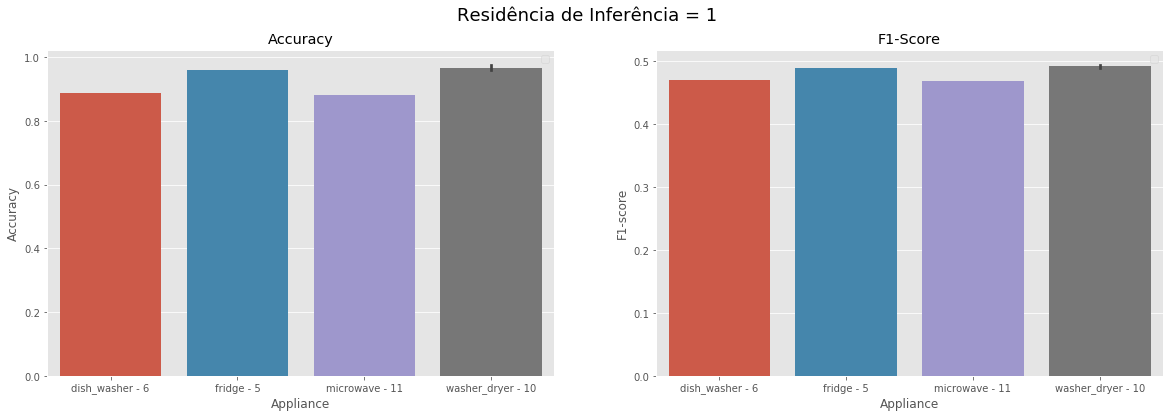

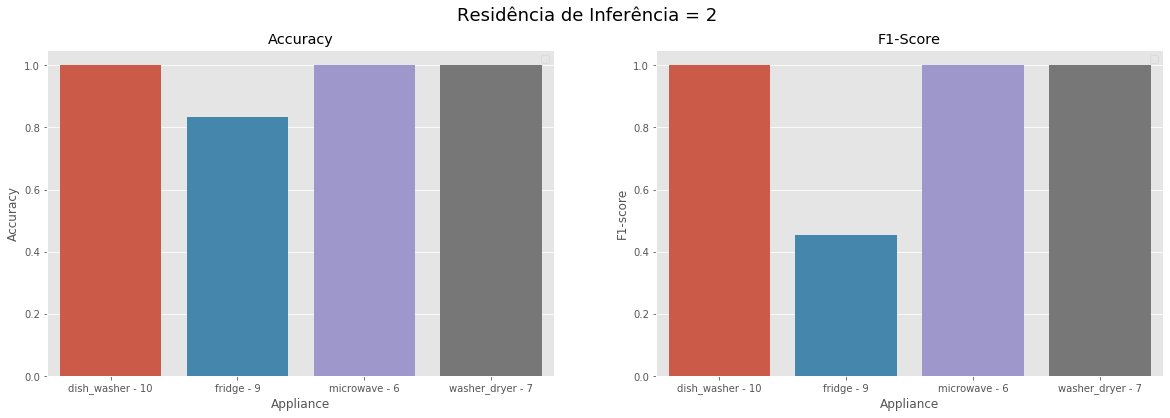

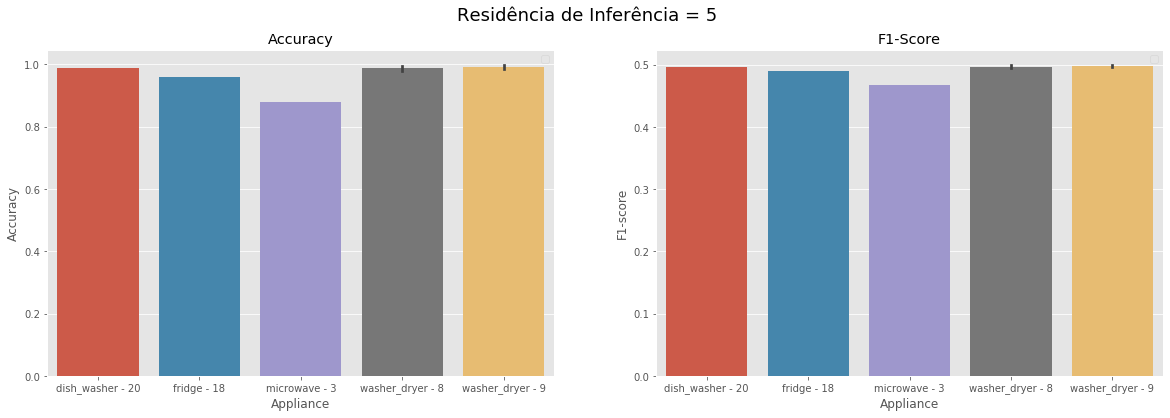

In [12]:
# Lendo resultados
df_generalizacao_superficial = pd.read_excel(
    os.path.join(caminho_dados_notebook, "df_generalizacao_superficial.xlsx"), 
    engine='openpyxl', index_col=[0]
)

for a in df_generalizacao_superficial['house'].unique():
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    df_ = df_generalizacao_superficial.query(f"house=='{a}'").reset_index()

    sns.barplot(x="appliance", y="acc",
                data=df_, ax=axes[0])
    axes[0].set(xlabel='Appliance', ylabel='Accuracy', title=f'Accuracy')
    axes[0].legend([])

    sns.barplot(x="appliance", y="f1",
                data=df_, ax=axes[1])
    axes[1].set(xlabel='Appliance', ylabel='F1-score', title=f'F1-Score')
    axes[1].legend([])

    plt.suptitle(f"Residência de Inferência = {a}", size=18);
    plt.show();
    

## Generalização cruzada

In [13]:
# from sklearn.base import clone
# Avaliar em cada uma das casas similares ao estudo (3)
# Dishwasher     - Casas 1, 2, 4, 5, 6
# Fridge         - Casas 1, 2,    5, 6
# Microwave      - Casas 1, 2,    5
# Washer Dryer 1 - Casas 1, 2, 4, 5, 6 
# Washer Dryer 2 - Casas 1, 2, 4, 5, 6

resultados_generalizacao = {
    "house_train": [], "house_test": [], 
    "appliance": [], 
    "on_train": [], "off_train": [],
    "on_test": [], "off_test": [],
    "acc": [], "f1": [], "auc": []}

RESIDENCIAS = [1,2,3,5]

for RESIDENCIA_TESTE in RESIDENCIAS:
    
    RESIDENCIAS_TREINO = list(set(RESIDENCIAS) - set([RESIDENCIA_TESTE]))
    
    for rotulo_aparelho in df_melhores_taxas_janelas.loc[
        df_melhores_taxas_janelas["carga"].isin([
            'dish_washer - 9','fridge - 7','microwave - 16',
            'washer_dryer - 13','washer_dryer - 14'
        ]), : ]["carga"].values:      
        
        print("="*80)
        print(f"# AVALIANDO GENERALIZAÇÃO CRUZADA: \n" +
              f"  - Aparelho              : {CARGA} (Instância #{INSTANCIA}) \n" +
              f"  - Residências de treino : {RESIDENCIAS_TREINO} \n" +
              f"  - Residência de teste   : {RESIDENCIA_TESTE}")
        print("="*80)
        print()
        
        # Informacoes da carga selecionada (TREINAMENTO)
        CARGA = rotulo_aparelho.split(" - ")[0]
        config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==rotulo_aparelho
        ].to_dict("records")[0]
        TAMANHO_JANELA = config_aparelho["janela"]
        
        # Percorrer instancias do aparelho na residencias
        print("# Preparando dados de treino...")
        X_treino = []
        y_treino = []
        for RESIDENCIA_TREINO in RESIDENCIAS_TREINO:
            print(f"  - Residência: {RESIDENCIA_TREINO}")
            
            for INSTANCIA_TREINO in instancia_aparelho_residencia(
                CARGA, RESIDENCIA_TREINO, base = redd):
                janelas = Janelas(**{
                    "base":redd,
                    "id_residencia": RESIDENCIA_TREINO,
                    "inicio_intervalo": PARAMETROS_DATASET_TREINO['inicio_intervalo'], #'2011-04-16 05:11:30', # MUDANCA
                    "fim_intervalo": PARAMETROS_DATASET_TREINO['fim_intervalo'], #'2011-04-23 08:43:26',
                    "debug": False    
                })

                # Carregando dados de treino
                X, y = carregar_dados_aparelho(
                    janelas=janelas,
                    instancia=INSTANCIA_TREINO,
                    aparelho=CARGA,
                    tamanho_janela=TAMANHO_JANELA,
                    taxa=TAXA,
                    eliminar_janelas_vazias=True
                )
                                
                X_treino.append(X)
                y_treino.append(y)
        
        X_treino = np.concatenate(X_treino, axis=0)
        y_treino = np.concatenate(y_treino, axis=0)
        
        # validar tamanho (limite memoria)
        if X_treino.shape[0] > 5000:
            _, idx = next(StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED).split(X_treino, y_treino))
            X_treino = X_treino[idx]
            y_treino = y_treino[idx]
            
        print("# Conjunto de treino obtido...")
        print(f"   - X: {X_treino.shape}")
        print(f"   - y: {y_treino.shape}")

        # Carregando dados de teste
        janelas = Janelas(**{
            "base":redd,
            "id_residencia": RESIDENCIA_TESTE,
            "inicio_intervalo": PARAMETROS_DATASET_TESTE['inicio_intervalo'],#'2011-04-16 01:11:27', #'2011-04-16 05:11:30', # MUDANCA
            "fim_intervalo": PARAMETROS_DATASET_TESTE['fim_intervalo'], #'2011-04-23 08:43:26',
            "debug": False    
        })
        
        print("# Preparando dados de teste...")
        for INSTANCIA in instancia_aparelho_residencia(
            CARGA, RESIDENCIA_TESTE, base = redd):

            X_teste, y_teste = carregar_dados_aparelho(
                janelas=janelas,
                instancia=INSTANCIA,
                aparelho=CARGA,
                tamanho_janela=TAMANHO_JANELA,
                taxa=TAXA,
                eliminar_janelas_vazias=True
            )
            
            print("     . Detalhes da amostragem (lotes):")
            print("     ---")
            print("     % Treinamento:")
            for item in Counter(y_treino).items():
                print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_treino)*100,1)}%)" )
            print("     % Teste:")
            for item in Counter(y_teste).items():
                print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
            print()

            # Treinando modelo
            clf = DLAFE(
                feature_extractor = transfer_learning.vgg16.VGG16(
                    input_shape=TAMANHO_IMAGEM_DLAFE,
                    weights='imagenet', 
                    include_top=False,
                    pooling='avg'
                ),
                preprocess_input = transfer_learning.vgg16.preprocess_input,
                classifier = clone(MODELO),
                rp_params = PARAMETROS_RP,
                input_shape = TAMANHO_IMAGEM_DLAFE,
                normalize=False
            )
            clf.fit(X_treino, y_treino)

            # Prevendo conjunto de teste
            print("     . Avaliando modelo...")
            y_hat = clf.predict(X_teste)

            # Incrementando resultados
            acuracia = accuracy_score(y_teste, y_hat)
            f1_macro = f1_score(y_teste, y_hat, average="macro")
            area_curva = roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5
            print("     . Resultados...")
            print(f"        -> Acurácia: {acuracia*100:.2f}%")
            print(f"        -> F1-macro: {f1_macro*100:.2f}%")
            print(f"        -> AUC     : {area_curva}")

            resultados_generalizacao["house_train"].append(RESIDENCIAS_TREINO)
            resultados_generalizacao["house_test"].append(RESIDENCIA_TESTE)
            resultados_generalizacao["appliance"].append(f'{CARGA} - {INSTANCIA}')
            resultados_generalizacao["acc"].append( acuracia )
            resultados_generalizacao["f1"].append( f1_macro )
            resultados_generalizacao["auc"].append( area_curva )
            dist = dict(Counter(y_treino))                        
            resultados_generalizacao["on_train"].append( dist[0] if 0 in dist else 0 )
            resultados_generalizacao["off_train"].append( dist[1] if 1 in dist else 0 )
            dist = dict(Counter(y_teste))                        
            resultados_generalizacao["on_test"].append( dist[0] if 0 in dist else 0 )
            resultados_generalizacao["off_test"].append( dist[1] if 1 in dist else 0 )

            print()
            
# Persistindo resultados
df_generalizacao_cruzada = pd.DataFrame(resultados_generalizacao)
df_generalizacao_cruzada["house_train"] = df_generalizacao_cruzada["house_train"].astype(str)
df_generalizacao_cruzada.to_excel(os.path.join(caminho_dados_notebook, "df_generalizacao_cruzada.xlsx"))

print("############################## FINAL MODEL RESULTS ##############################")
display(df_generalizacao_cruzada.groupby(["house_train","house_test","appliance"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    #"auc": ["mean", "std", "max", "min"]
}))

# AVALIANDO GENERALIZAÇÃO CRUZADA: 
  - Aparelho              : washer_dryer (Instância #9) 
  - Residências de treino : [2, 3, 5] 
  - Residência de teste   : 1

# Preparando dados de treino...
  - Residência: 2

  - Residência: 3
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

  - Residência: 5
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter

Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.

     . Detalhes da amostragem (lotes):
     ---
     % Treinamento:
       - Classe `0`: 5303 amostras (98.2%)
       - Classe `1`: 95 amostras (1.8%)
     % Teste:
       - Classe `0`: 1361 amostras (100.0%)

     . Avaliando modelo...
     . Resultados...
        -> Acurácia: 98.38%
        -> F1-macro: 49.59%
        -> AUC     : 0.5

# AVALIANDO GENERALIZAÇÃO CRUZADA: 
  - Aparelho              : washer_dryer (Instância #10) 
  - Residências de treino : [2, 3, 5] 
  - Residência de teste   : 1

# Preparando dados de treino...
  - Residência: 2

  - Residência: 3
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nes


  - Residência: 5
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.

# Conjunto de treino obtido...
   - X: (1381, 900)
   - y: (1381,)
# Preparando dados de teste...

     . Detalhes da amostragem (lotes):
     ---
     % Treinamento:
       - Classe `0`: 1248 amostras (90.4%)
       - Classe `1`: 133 amostras (9.6%)
     % Teste:
       - Classe `0`: 8 amostras (100.0%)

     . Avaliando modelo...
     . Resultados...
        -> Acurácia: 100.00%
        -> F1-macro: 100.00%
        -> AUC     : 0.5

#

Meter 3 is in a nested meter group. Retrieving just the ElecMeter.
Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.

  - Residência: 2

  - Residência: 5
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.

# Conjunto de treino obtido...
   - X: (1273, 1080)
   - y: (1273,)
# Preparando dados de teste...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just


# Conjunto de treino obtido...
   - X: (3973, 360)
   - y: (3973,)
# Preparando dados de teste...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     . Detalhes da amostragem (lotes):
     ---
     % Treinamento:
       - Classe `0`: 3936 amostras (99.1%)
       - Classe `1`: 37 amostras (0.9%)
     % Teste:
       - Classe `0`: 770 amostras (95.1%)
       - Classe `1`: 40 amostras (4.9%)

     . Avaliando modelo...
     . Resultados...
        -> Acurácia: 94.94%
        -> F1-macro: 51.03%
        -> AUC     : 0.5112012987012987

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     . Detalhes da amostragem (lotes):
     ---
     % Treinamento:
       - Classe `0`: 3936 amos

Meter 4 is in a nested meter group. Retrieving just the ElecMeter.
Meter 10 is in a nested meter group. Retrieving just the ElecMeter.

  - Residência: 2

  - Residência: 3
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

# Conjunto de treino obtido...
   - X: (7330, 60)
   - y: (7330,)
# Preparando dados de teste...
Meter 8 is in a nested meter group. Retrieving just the ElecMeter.
Meter 9 is in a nested meter group. Retrieving just the ElecMeter.
Meter 12 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 8 is in a nested meter group. Retrieving jus

acc                      \
                                              mean       std       max   
house_train house_test appliance                                         
[1, 2, 3]   5          dish_washer - 20   0.986301       NaN  0.986301   
                       fridge - 18        1.000000       NaN  1.000000   
                       microwave - 3      0.793103       NaN  0.793103   
                       washer_dryer - 8   0.987169  0.011522  0.995316   
                       washer_dryer - 9   0.991251  0.007406  0.996487   
[1, 2, 5]   3          dish_washer - 9    0.958333       NaN  0.958333   
                       fridge - 7         0.941606       NaN  0.941606   
                       microwave - 16     0.914110       NaN  0.914110   
                       washer_dryer - 13  0.955250  0.008297  0.961117   
                       washer_dryer - 14  0.944003  0.006360  0.948501   
[1, 3, 5]   2          dish_washer - 10   1.000000       NaN  1.000000   
                       fridge - 9         1.000000       NaN  1.000000   
                       microwave - 6      1.000000       NaN  1.000000   
                       washer_dryer - 7   1.000000  0.000000  1.000000   
[2, 3, 5]   1          dish_washer - 6    0.886957       NaN  0.886957   
                       fridge - 5         0.961039       NaN  0.961039   
                       microwave - 11     0.858696       NaN  0.858696   
                       washer_dryer - 10  0.976567  0.010279  0.983835   

                                                          f1            \
                                               min      mean       std   
house_train house_test appliance                                         
[1, 2, 3]   5          dish_washer - 20   0.986301  0.496552       NaN   
                       fridge - 18        1.000000  1.000000       NaN   
                       microwave - 3      0.793103  0.442308       NaN   
                       washer_dryer - 8   0.979021  0.496763  0.002918   
                       washer_dryer - 9   0.986014  0.497800  0.001868   
[1, 2, 5]   3          dish_washer - 9    0.958333  0.541967       NaN   
                       fridge - 7         0.941606  0.484962       NaN   
                       microwave - 16     0.914110  0.717329       NaN   
                       washer_dryer - 13  0.949383  0.524199  0.019718   
                       washer_dryer - 14  0.939506  0.513962  0.014099   
[1, 3, 5]   2          dish_washer - 10   1.000000  1.000000       NaN   
                       fridge - 9         1.000000  1.000000       NaN   
                       microwave - 6      1.000000  1.000000       NaN   
                       washer_dryer - 7   1.000000  1.000000  0.000000   
[2, 3, 5]   1          dish_washer - 6    0.886957  0.470046       NaN   
                       fridge - 5         0.961039  0.490066       NaN   
                       microwave - 11     0.858696  0.461988       NaN   
                       washer_dryer - 10  0.969298  0.494065  0.002631   

                                                              
                                               max       min  
house_train house_test appliance                              
[1, 2, 3]   5          dish_washer - 20   0.496552  0.496552  
                       fridge - 18        1.000000  1.000000  
                       microwave - 3      0.442308  0.442308  
                       washer_dryer - 8   0.498826  0.494700  
                       washer_dryer - 9   0.499120  0.496479  
[1, 2, 5]   3          dish_washer - 9    0.541967  0.541967  
                       fridge - 7         0.484962  0.484962  
                       microwave - 16     0.717329  0.717329  
                       washer_dryer - 13  0.538142  0.510256  
                       washer_dryer - 14  0.523931  0.503993  
[1, 3, 5]   2          dish_washer - 10   1.000000  1.000000  
                       fridge - 9         1.000000  1.0

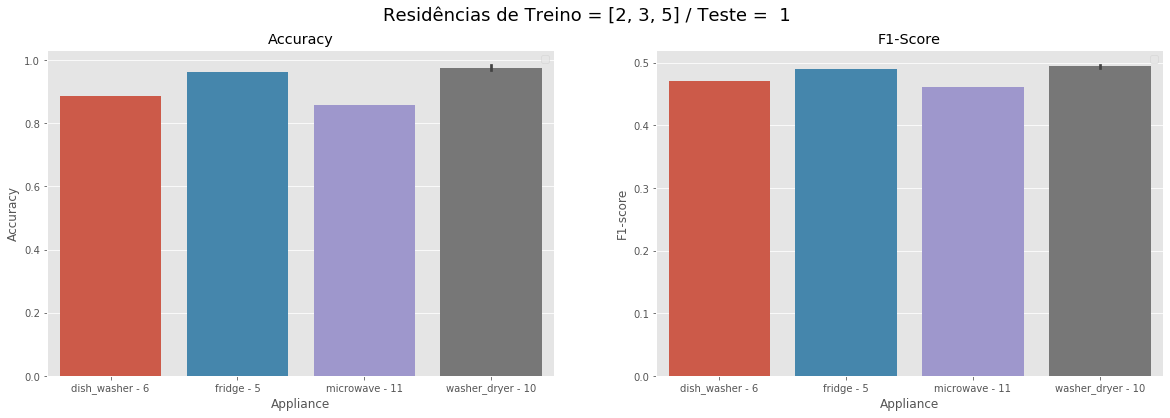

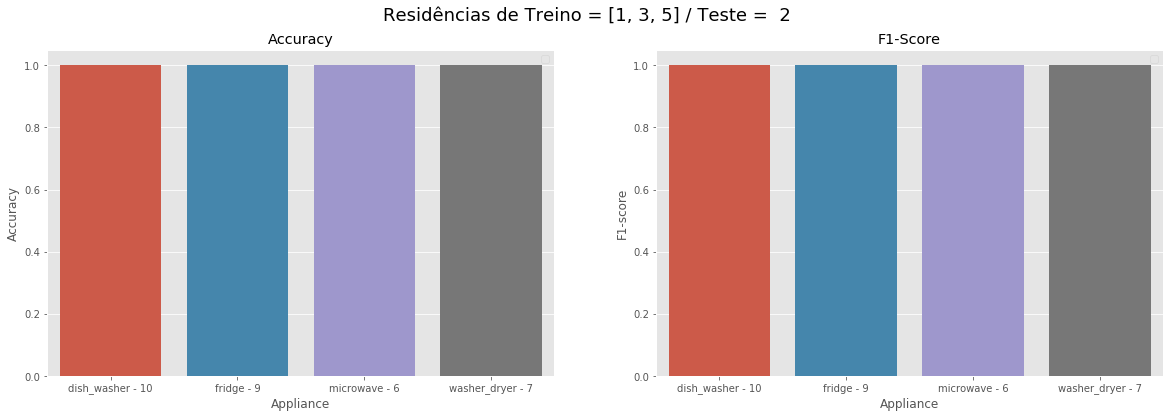

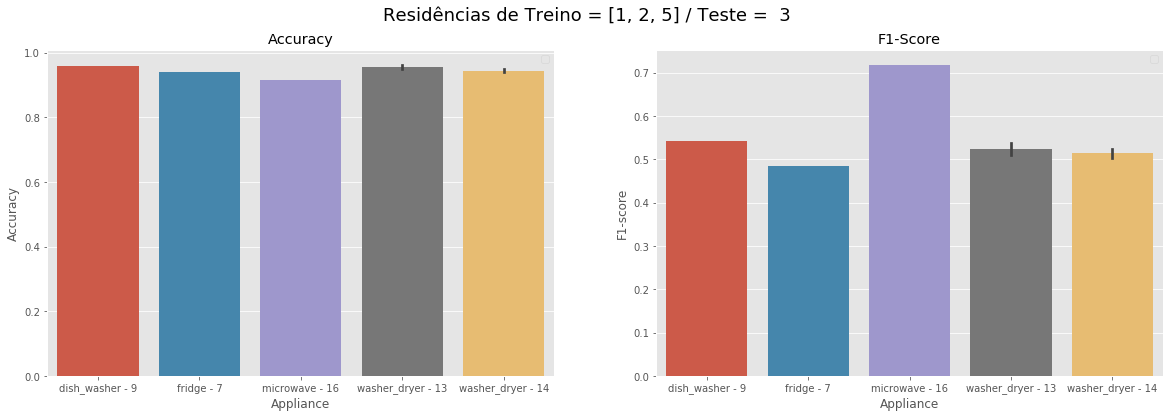

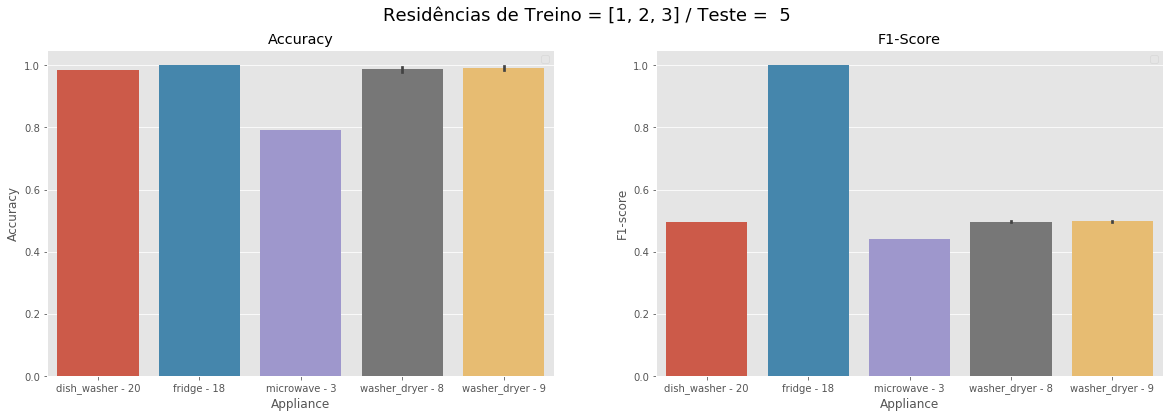

In [14]:
# Lendo resultados
df_generalizacao_cruzada = pd.read_excel(
    os.path.join(caminho_dados_notebook, "df_generalizacao_cruzada.xlsx"), 
    engine='openpyxl', index_col=[0]
)

for a in df_generalizacao_cruzada['house_train'].unique():
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    df_ = df_generalizacao_cruzada.query(f"house_train=='{a}'").reset_index()

    sns.barplot(x="appliance", y="acc",
                data=df_, ax=axes[0])
    axes[0].set(xlabel='Appliance', ylabel='Accuracy', title=f'Accuracy')
    axes[0].legend([])#frameon=False, loc='best', ncol=2); 

    sns.barplot(x="appliance", y="f1",
                data=df_, ax=axes[1])
    axes[1].set(xlabel='Appliance', ylabel='F1-score', title=f'F1-Score')
    axes[1].legend([])#frameon=False, loc='best', ncol=2); 

    resid_treino = [int(a_) for a_ in a.replace('[','').replace(']','').split(', ')]
    resid_teste = list(set([1,2,3,5]) - set(resid_treino))[0]
    plt.suptitle(f"Residências de Treino = {resid_treino} / Teste =  {resid_teste}", size=18);
    plt.show();
    

**CONCLUSÕES PARCIAIS:**
    - Os atributos latentes aprendidos no aparelho `fridge` são intercambiáveis entre as cadas 1, 2 e 5;
    

## Impacto de Diferentes Janelas por Aparelho

In [23]:
# Modelos de classificacao adotados - com base no estudo 24

resultados_modelo = {
    "appliance": [], "fold": [],
    "acc": [], "f1": [], "auc": [], 
    "base": [], "window_length": [],
}

# Intervalo fixo para todos aparelhos
janelas = [30, 60, 90, 180, 360, 540, 720, 900, 1080, 2040]

# Carregando dados de treino/teste (similar ao cabeçalho - evitar problemas de execucao anterior)
janelas_treino = Janelas(
    base=DataSet(arquivo_dataset),
    id_residencia=3,
    inicio_intervalo='2011-04-16',
    fim_intervalo='2011-05-16',
    debug = False
)
janelas_teste = Janelas(
    base=DataSet(arquivo_dataset),
    id_residencia=3,
    inicio_intervalo='2011-05-17',
    fim_intervalo='2011-05-30',
    debug = False
)

# Processamento de cada aparelho
for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        [
            'dish_washer - 9','fridge - 7','microwave - 16',
            'washer_dryer - 13', 'washer_dryer - 14'
        ]),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    for TAMANHO_JANELA in janelas:#[rotulo_aparelho]:
        
        print(f" . TAMANHO_JANELA = {TAMANHO_JANELA}...\n")
        
        # Informacoes da carga selecionada
        CARGA = rotulo_aparelho.split(" - ")[0]
        INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

        config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==rotulo_aparelho
        ].to_dict("records")[0]

        #######################################################################
        #                AVALIACAO 1 - Base de treino / CV                    #
        #######################################################################
        # Extrair series divididas em janelas para cada medidor
        print("   - Base de TREINO\n")
        print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))
        X, y = carregar_dados_aparelho(
            janelas=janelas_treino,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )
        print("     -> Detalhes da amostragem (lotes):")
        print("     ---")
        for item in Counter(y).items():
            print(f"        - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
        print()

        y_true, y_pred  = [], []

        print(f"     -> Avaliando modelo (CV - {skf.n_splits} folds)...\n")
        for it, (idx_treino, idx_teste) in tqdm_notebook(enumerate(skf.split(X, y)), total=skf.n_splits):

            # Preparando lotes
            X_treino, X_teste = X[idx_treino], X[idx_teste]
            y_treino, y_teste = y[idx_treino], y[idx_teste]
            
            # TODO: finalizar implementacao
            if np.unique(y_treino).size > 1:

                # Treinando modelo
                reset_tf_session(model_name='dlafe')
                dlafe = DLAFE(
                    feature_extractor = transfer_learning.vgg16.VGG16(
                        input_shape=TAMANHO_IMAGEM_DLAFE,
                        weights='imagenet', 
                        include_top=False,
                        pooling='avg'
                    ),
                    preprocess_input = transfer_learning.vgg16.preprocess_input,
                    classifier = clone(MODELO),
                    rp_params = PARAMETROS_RP,
                    input_shape = TAMANHO_IMAGEM_DLAFE,
                    normalize=False
                )
                dlafe.fit(X_treino, y_treino)

                # Prevendo conjunto de teste
                y_hat = dlafe.predict(X_teste)

                # Incrementando resultados
                resultados_modelo["appliance"].append(rotulo_aparelho)
                resultados_modelo["fold"].append(it+1)
                resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
                resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
                resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
                resultados_modelo["base"].append("treino")
                resultados_modelo["window_length"].append(TAMANHO_JANELA)

                # Extendendo rotulos (analise global)
                y_true.extend(y_teste)
                y_pred.extend(y_hat)
                
            else:
                
                # Incrementando resultados
                resultados_modelo["appliance"].append(rotulo_aparelho)
                resultados_modelo["fold"].append(it+1)
                resultados_modelo["acc"].append( 0 )
                resultados_modelo["f1"].append( 0 )
                resultados_modelo["auc"].append( 0 )
                resultados_modelo["base"].append("treino")
                resultados_modelo["window_length"].append(TAMANHO_JANELA)
                

    #         print(f"       _ Classification Report fold #{it}:")
    #         print()
    #         print(classification_report(y_teste, y_hat))

        #######################################################################
        #                 AVALIACAO 2 - Base de teste / CV                    #
        #######################################################################
        print("   - Base de TESTE\n")
        print("     -> Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
            TAXA, TAMANHO_JANELA
        ))

        # Avaliar na base de teste
        X_teste, y_teste = carregar_dados_aparelho(
            janelas=janelas_teste,
            instancia=INSTANCIA,
            aparelho=CARGA,
            tamanho_janela=TAMANHO_JANELA,
            taxa=TAXA,
            eliminar_janelas_vazias=True
        )

        print("     -> Detalhes da amostragem (lotes):")
        print("     ---")
        for item in Counter(y_teste).items():
            print(f"       - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y_teste)*100,1)}%)" )
        print()


        # Treinando modelo
        reset_tf_session(model_name='dlafe')
        dlafe = DLAFE(
            feature_extractor = transfer_learning.vgg16.VGG16(
                input_shape=TAMANHO_IMAGEM_DLAFE,
                weights='imagenet', 
                include_top=False,
                pooling='avg'
            ),
            preprocess_input = transfer_learning.vgg16.preprocess_input,
            classifier = clone(MODELO),
            rp_params = PARAMETROS_RP,
            input_shape = TAMANHO_IMAGEM_DLAFE,
            normalize=False
        )
        dlafe.fit(X, y)

        # Prevendo conjunto de teste
        y_hat = dlafe.predict(X_teste)

        # Incrementando resultados
        resultados_modelo["appliance"].append(rotulo_aparelho)
        resultados_modelo["fold"].append(it+1)
        resultados_modelo["acc"].append( accuracy_score(y_teste, y_hat) )
        resultados_modelo["f1"].append( f1_score(y_teste, y_hat, average="macro") )
        resultados_modelo["auc"].append(roc_auc_score(y_teste, y_hat) if np.unique(y_teste).shape[0]>1 else 0.5)
        resultados_modelo["base"].append("teste")
        resultados_modelo["window_length"].append(TAMANHO_JANELA)

        print()
        print("   - Final Results:")
        print("   ---")
        print()

        print("      -> Classification Report:")
        print()
        print(classification_report(y_true, y_pred))
        print("      -> Confusion Matrix:")
        print()
        print(confusion_matrix(y_true, y_pred))

    print()
    
# Consolidating DataFrame
df_resultados_janelas = pd.DataFrame(resultados_modelo)
df_resultados_janelas.to_excel(os.path.join(caminho_dados_notebook, "df_resultados_janelas.xlsx"))
    
print("############################## FINAL MODEL RESULTS ##############################")
display(df_resultados_janelas.groupby(["appliance","window_length","base"]).agg({
    "acc": ["mean", "std", "max", "min"],
    "f1": ["mean", "std", "max", "min"],
    "auc": ["mean", "std", "max", "min"]
}))

* Aparelho DISH_WASHER - 9:

 . TAMANHO_JANELA = 30...

   - Base de TREINO

     -> Carregando dados (taxa=2, janela=30)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
        - Classe `0`: 14840 amostras (98.7%)
        - Classe `1`: 193 amostras (1.3%)

     -> Avaliando modelo (CV - 10 folds)...



  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=30)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 9534 amostras (98.6%)
       - Classe `1`: 131 amostras (1.4%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 4766 amostras (98.6%)
       - Classe `1`: 69 amostras (1.4%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=90)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 3176 amostras (98.5%)
       - Classe `1`: 50 amostras (1.5%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=180)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 1585 amostras (98.2%)
       - Classe `1`: 29 amostras (1.8%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 792 amostras (97.8%)
       - Classe `1`: 18 amostras (2.2%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=540)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 527 amostras (97.2%)
       - Classe `1`: 15 amostras (2.8%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 395 amostras (96.8%)
       - Classe `1`: 13 amostras (3.2%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 314 amostras (96.3%)
       - Classe `1`: 12 amostras (3.7%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 263 amostras (96.0%)
       - Classe `1`: 11 amostras (4.0%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=2040)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 137 amostras (93.2%)
       - Classe `1`: 10 amostras (6.8%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=30)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 4103 amostras (42.5%)
       - Classe `0`: 5562 amostras (57.5%)

Virtual devices cannot be modified after being initialized

   - Fina

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 2215 amostras (45.8%)
       - Classe `0`: 2620 amostras (54.2%)

Virtual devices cannot be modified after being initialized

   - Fina

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=90)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 1583 amostras (49.1%)
       - Classe `0`: 1643 amostras (50.9%)

Virtual devices cannot be modified after being initialized

   - Fina

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=180)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 937 amostras (58.1%)
       - Classe `0`: 677 amostras (41.9%)

Virtual devices cannot be modified after being initialized

   - Final

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 598 amostras (73.8%)
       - Classe `0`: 212 amostras (26.2%)

Virtual devices cannot be modified after being initialized

   - Final

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=540)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 476 amostras (87.8%)
       - Classe `0`: 66 amostras (12.2%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 391 amostras (95.8%)
       - Classe `0`: 17 amostras (4.2%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 319 amostras (97.9%)
       - Classe `0`: 7 amostras (2.1%)

Virtual devices cannot be modified after being initialized

   - Final Re

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 269 amostras (98.2%)
       - Classe `0`: 5 amostras (1.8%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=2040)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `1`: 145 amostras (98.6%)
       - Classe `0`: 2 amostras (1.4%)

Virtual devices cannot be modified after being initialized

   - Final Results:
   ---

      -> Classification Report:

          

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=30)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 9585 amostras (99.2%)
       - Classe `1`: 80 amostras (0.8%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 4783 amostras (98.9%)
       - Classe `1`: 52 amostras (1.1%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=90)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 3186 amostras (98.8%)
       - Classe `1`: 40 amostras (1.2%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=180)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 1587 amostras (98.3%)
       - Classe `1`: 27 amostras (1.7%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 786 amostras (97.0%)
       - Classe `1`: 24 amostras (3.0%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=540)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 521 amostras (96.1%)
       - Classe `1`: 21 amostras (3.9%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 386 amostras (94.6%)
       - Classe `1`: 22 amostras (5.4%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 306 amostras (93.9%)
       - Classe `1`: 20 amostras (6.1%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 254 amostras (92.7%)
       - Classe `1`: 20 amostras (7.3%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=2040)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 128 amostras (87.1%)
       - Classe `1`: 19 amostras (12.9%)

Virtual devices cannot be modified after being initialized

   - Final

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=30)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 9343 amostras (96.7%)
       - Classe `1`: 322 amostras (3.3%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 4643 amostras (96.0%)
       - Classe `1`: 192 amostras (4.0%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=90)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 3094 amostras (95.9%)
       - Classe `1`: 132 amostras (4.1%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=180)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 1544 amostras (95.7%)
       - Classe `1`: 70 amostras (4.3%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 770 amostras (95.1%)
       - Classe `1`: 40 amostras (4.9%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=540)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 514 amostras (94.8%)
       - Classe `1`: 28 amostras (5.2%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 385 amostras (94.4%)
       - Classe `1`: 23 amostras (5.6%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 307 amostras (94.2%)
       - Classe `1`: 19 amostras (5.8%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 256 amostras (93.4%)
       - Classe `1`: 18 amostras (6.6%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=2040)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 134 amostras (91.2%)
       - Classe `1`: 13 amostras (8.8%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=30)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 9167 amostras (94.8%)
       - Classe `1`: 498 amostras (5.2%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=60)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 4582 amostras (94.8%)
       - Classe `1`: 253 amostras (5.2%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=90)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 3054 amostras (94.7%)
       - Classe `1`: 172 amostras (5.3%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=180)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 1526 amostras (94.5%)
       - Classe `1`: 88 amostras (5.5%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=360)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 762 amostras (94.1%)
       - Classe `1`: 48 amostras (5.9%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=540)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 508 amostras (93.7%)
       - Classe `1`: 34 amostras (6.3%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=720)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 382 amostras (93.6%)
       - Classe `1`: 26 amostras (6.4%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=900)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 303 amostras (92.9%)
       - Classe `1`: 23 amostras (7.1%)

Virtual devices cannot be modified after being initialized

   - Final R

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=1080)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 254 amostras (92.7%)
       - Classe `1`: 20 amostras (7.3%)

Virtual devices cannot be modified after being initialized

   - Final 

  0%|          | 0/10 [00:00<?, ?it/s]

Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
Virtual devices cannot be modified after being initialized
   - Base de TESTE

     -> Carregando dados (taxa=2, janela=2040)...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

     -> Detalhes da amostragem (lotes):
     ---
       - Classe `0`: 133 amostras (90.5%)
       - Classe `1`: 14 amostras (9.5%)

Virtual devices cannot be modified after being initialized

   - Final 

acc                      \
                                            mean       std       max   
appliance         window_length base                                   
dish_washer - 9   30            teste   0.986446       NaN  0.986446   
                                treino  0.987162  0.000317  0.987359   
                  60            teste   0.985729       NaN  0.985729   
                                treino  0.986472  0.000559  0.986737   
                  90            teste   0.984501       NaN  0.984501   
...                                          ...       ...       ...   
washer_dryer - 14 900           treino  0.980468  0.020590  1.000000   
                  1080          teste   0.989051       NaN  0.989051   
                                treino  0.983555  0.019365  1.000000   
                  2040          teste   0.986395       NaN  0.986395   
                                treino  0.982609  0.030400  1.000000   

                                                        f1            \
                                             min      mean       std   
appliance         window_length base                                   
dish_washer - 9   30            teste   0.986446  0.496588       NaN   
                                treino  0.986702  0.496770  0.000080   
                  60            teste   0.985729  0.496407       NaN   
                                treino  0.985411  0.496595  0.000142   
                  90            teste   0.984501  0.496095       NaN   
...                                          ...       ...       ...   
washer_dryer - 14 900           treino  0.941176  0.878923  0.163491   
                  1080          teste   0.989051  0.956524       NaN   
                                treino  0.952381  0.902360  0.112193   
                  2040          teste   0.986395  0.957807       NaN   
                                treino  0.913043  0.943570  0.098604   

                                                                 auc  \
                                             max       min      mean   
appliance         window_length base                                   
dish_washer - 9   30            teste   0.496588  0.496588  0.500000   
                                treino  0.496820  0.496653  0.500000   
                  60            teste   0.496407  0.496407  0.500000   
                                treino  0.496662  0.496326  0.500000   
                  90            teste   0.496095  0.496095  0.500000   
...                                          ...       ...       ...   
washer_dryer - 14 900           treino  1.000000  0.484848  0.894834   
                  1080          teste   0.956524  0.956524  0.925000   
                                treino  1.000000  0.737500  0.889197   
                  2040          teste   0.957807  0.957807  0.928571   
                                treino  1.000000  0.726190  0.945238   

                                                                      
                                             std       max       min  
appliance         window_length base                                  
dish_washer - 9   30            teste        NaN  0.500000  0.500000  
                                treino  0.000000  0.500000  0.500000  
                  60            teste        NaN  0.500000  0.500000  
                                treino  0.000000  0.500000  0.500000  
                  90            teste        NaN  0.500000  0.500000  
...                                          ...       ...       ...  
washer_dryer - 14 900           treino  0.180278  1.000000  0.489796  
                  1080          teste        NaN  0.925000  0.925000  
                                treino  0.142358  1.000000  0.666667  
                  2040          teste        NaN  0.928571  0.928571  
                                treino  0.109570  1.000000  0.726190  

[100 rows x 12 columns]

In [24]:
# Lendo resultados
df_resultados_janelas = pd.read_excel(
    os.path.join(caminho_dados_notebook, "df_resultados_janelas.xlsx"), 
    engine='openpyxl',
    index_col=0
)

# Consolidado dos aparelhos (f1)
df_consolidado = df_resultados_janelas[df_resultados_janelas['base']=='teste']
data_f1 = {a: [] for a in df_consolidado['appliance'].unique()}
data_acc = {a: [] for a in df_consolidado['appliance'].unique()}
for a in df_consolidado['appliance'].unique():
    for w in df_consolidado['window_length'].unique():
        data_f1[a].append(
            df_consolidado[(df_consolidado['appliance']==a) & 
                           (df_consolidado['window_length']==w)]['f1'].values[0]
        )
        data_acc[a].append(
            df_consolidado[(df_consolidado['appliance']==a) & 
                           (df_consolidado['window_length']==w)]['acc'].values[0]
        )
data_f1['window_length'] = df_consolidado['window_length'].unique()
df_consolidado_f1 = pd.DataFrame(data_f1)
data_acc['window_length'] = df_consolidado['window_length'].unique()
df_consolidado_acc = pd.DataFrame(data_acc)

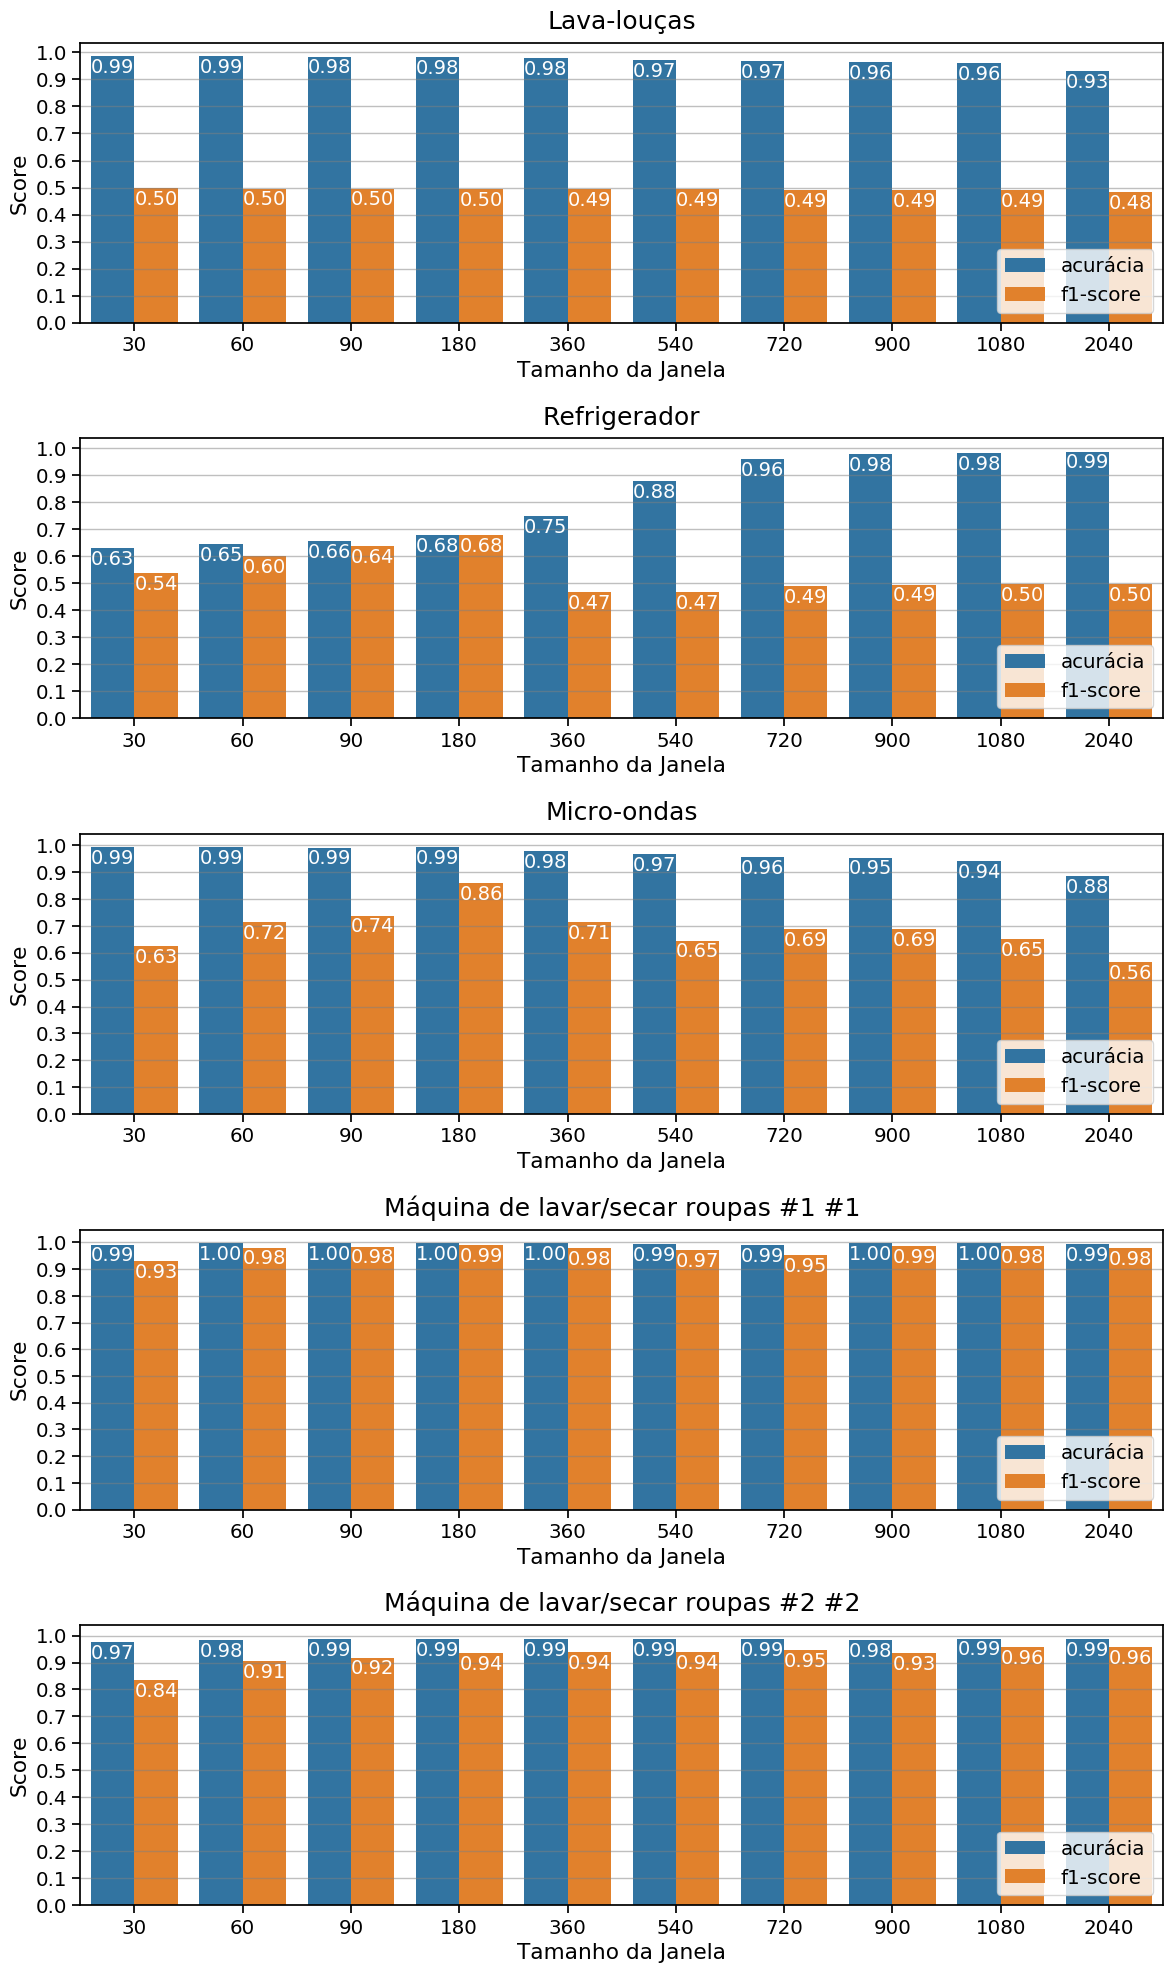

In [25]:
# Graficos separados por aparelho
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.titlepad': 10
})
df_analise_janelas = df_consolidado[['acc','f1']].stack().reset_index()
df_analise_janelas['level_1'] = df_analise_janelas['level_1'].apply(lambda x: 'acurácia' if x == 'acc' else 'f1-score')
df_analise_janelas['appliance'] = df_analise_janelas['level_0'].apply(
    lambda x: df_consolidado[df_consolidado.index==x]['appliance'].values[0])
df_analise_janelas['window_length'] = df_analise_janelas['level_0'].apply(
    lambda x: df_consolidado[df_consolidado.index==x]['window_length'].values[0])
df_analise_janelas = df_analise_janelas.rename(columns={
    'level_1': 'metric',
    0: 'value'
}).drop(columns=['level_0'])

fig, axs = plt.subplots(5,1, figsize=(12, 20))

appliances = {
    'dish_washer - 9': 'Lava-louças',
    'fridge - 7': 'Refrigerador',
    'microwave - 16': 'Micro-ondas',
    'washer_dryer - 13': 'Máquina de lavar/secar roupas #1',
    'washer_dryer - 14': 'Máquina de lavar/secar roupas #2'
}

for a, ax in zip(df_resultados_janelas['appliance'].unique(), axs):
    
    # Appliance label
    # appliance = a.split("-")[0].strip().replace("_"," ").lower()
    appliance = appliances[a]
    if all(k in a for k in ['washer', '13']):
        appliance += ' #1'
    elif all(k in a for k in ['washer', '14']):
        appliance += ' #2'
    
    df_ = df_analise_janelas.query(f"appliance == '{a}'").reset_index()
    
    g=sns.barplot(x="window_length", y="value", hue="metric", data=df_, ax=ax)
    # Remove legend title
    g.legend_.set_title(None) 
    # Inserting metrics over the bars
    for bar in g.patches:
        g.annotate(format(bar.get_height(), '.2f'), 
        (bar.get_x() + bar.get_width() / 2, 
        bar.get_height()), ha='center', va='center',
        size=14, 
        xytext=(0, -8),
        textcoords='offset points', 
        color='white',)
    ax.set(
        title=appliance, 
        ylabel='Score', xlabel='Tamanho da Janela',     
        # #xticklabels=df_avg['feature'],
        yticks=np.arange(0, np.max(df_['value'])+.1, .1)  
    );
    ax.legend(loc='lower right');
plt.tight_layout();
plt.show();
fig.savefig(
    os.path.join(
        caminho_imagens_notebook,
        f'4_janelas.png', 
    ),
    format='png', 
    dpi=300,
    bbox_inches='tight', 
    pad_inches=0
)

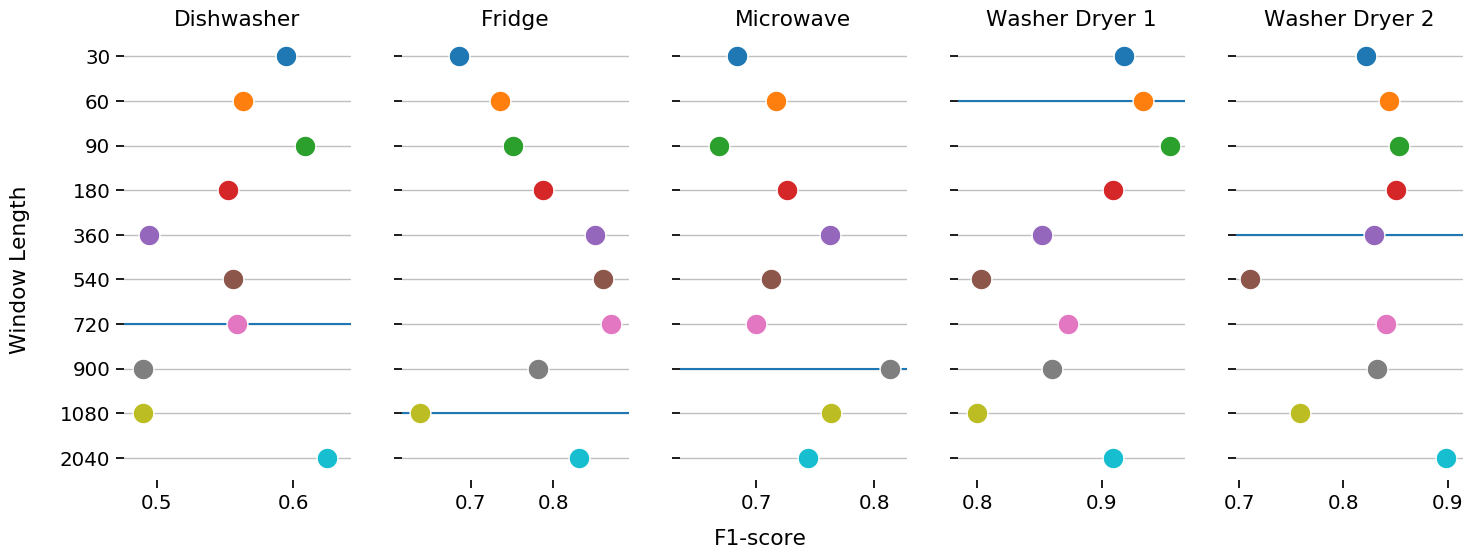

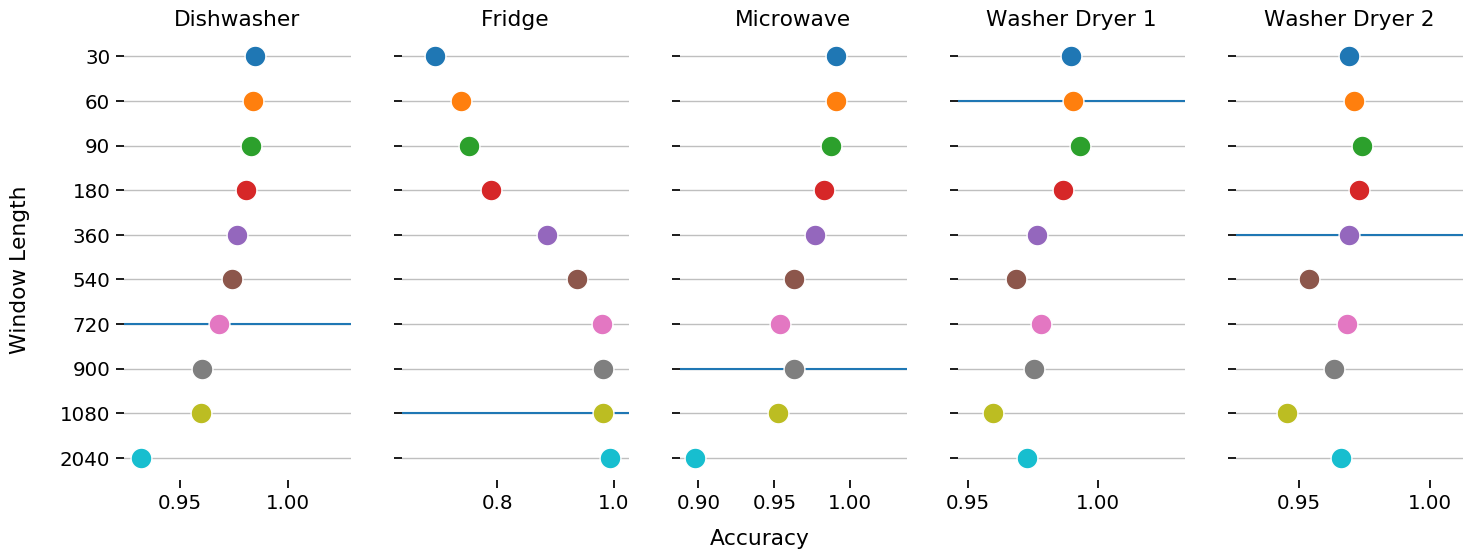

In [13]:


# Plot F1
g = sns.PairGrid(df_consolidado_f1,
                 x_vars=df_consolidado_f1.columns[:-1], y_vars=["window_length"],
                 height=10, aspect=.25)
g.map(sns.stripplot, size=15, orient="h", jitter=False,
       linewidth=1, edgecolor="w")
g.set(xlabel="", ylabel="")
titles = ["Dishwasher", "Fridge", "Microwave", "Washer Dryer 1", "Washer Dryer 2"]
for i, (ax, title) in enumerate(zip(g.axes.flat, titles)):
    # Set a different title for each axes
    ax.set(title=title)
    ax.axhline(
        y=np.argwhere(
            df_consolidado_f1['window_length']==df_melhores_taxas_janelas['janela'].values[i]
        )[0][0]
    )
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)
g.fig.set_size_inches(15, 5);
g.fig.text(0.5, -0.05, 'F1-score', ha='center');
g.fig.text(0, 0.5, 'Window Length', va='center', rotation='vertical');
plt.show();
g.fig.savefig(
    os.path.join(
        caminho_imagens_notebook,
        f'4_janelas_f1.png', 
    ),
    format='png', 
    dpi=300,
    bbox_inches='tight', 
    pad_inches=0
)

# Plot ACC
g = sns.PairGrid(df_consolidado_acc,
                 x_vars=df_consolidado_acc.columns[:-1], y_vars=["window_length"],
                 height=10, aspect=.25)
g.map(sns.stripplot, size=15, orient="h", jitter=False,
       linewidth=1, edgecolor="w")
g.set(xlabel="", ylabel="")
titles = ["Dishwasher", "Fridge", "Microwave", "Washer Dryer 1", "Washer Dryer 2"]
for i, (ax, title) in enumerate(zip(g.axes.flat, titles)):
    # Set a different title for each axes
    ax.set(title=title)
    ax.axhline(
        y=np.argwhere(
            df_consolidado_acc['window_length']==df_melhores_taxas_janelas['janela'].values[i]
        )[0][0]
    )
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)
g.fig.set_size_inches(15, 5);
g.fig.text(0.5, -0.05, 'Accuracy', ha='center');
g.fig.text(0, 0.5, 'Window Length', va='center', rotation='vertical');
plt.show();
g.fig.savefig(
    os.path.join(
        caminho_imagens_notebook,
        f'4_janelas_acuracia.png', 
    ),
    format='png', 
    dpi=300,
    bbox_inches='tight', 
    pad_inches=0
)

dish_washer - 9 (taxa=`2`, janela=`720`)


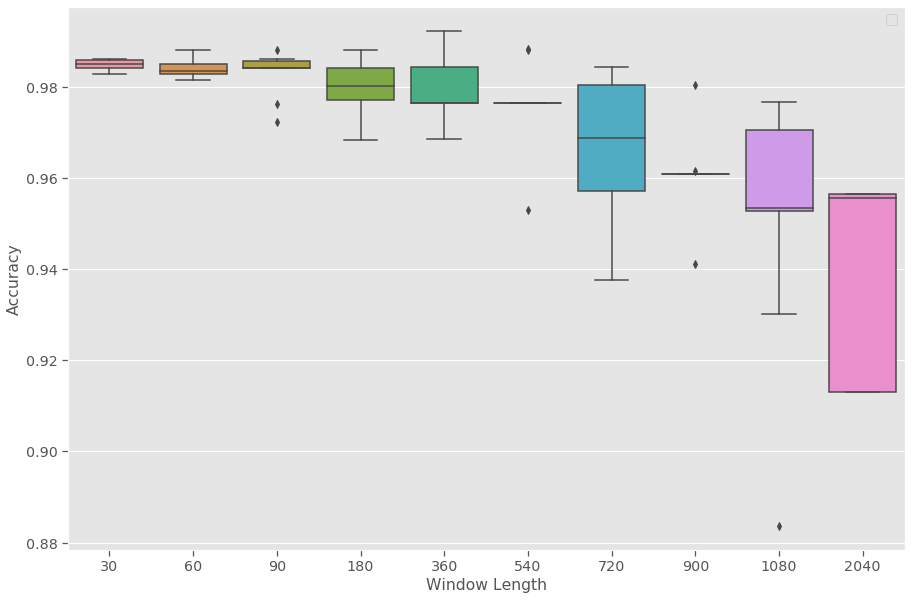

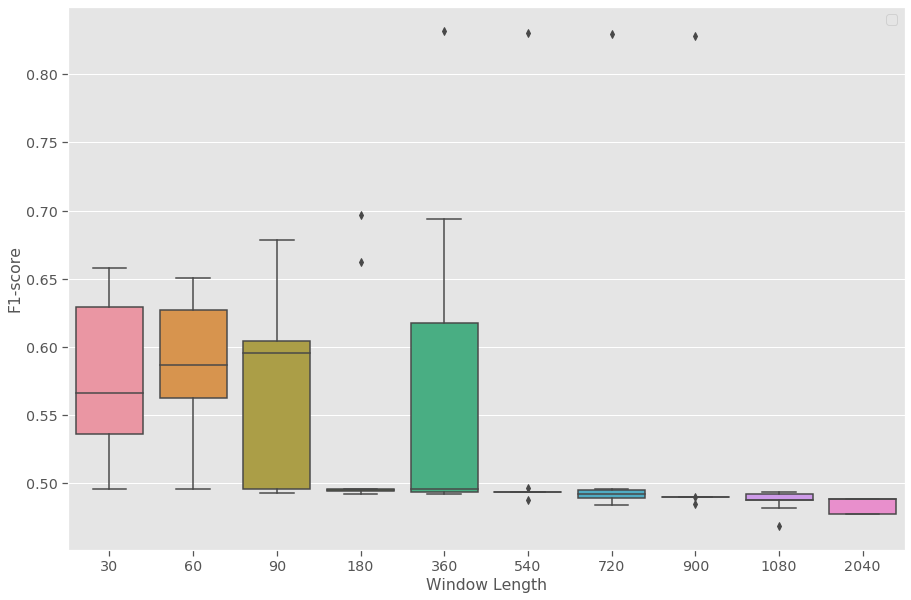

dish_washer - 9 (taxa=`2`, janela=`720`)


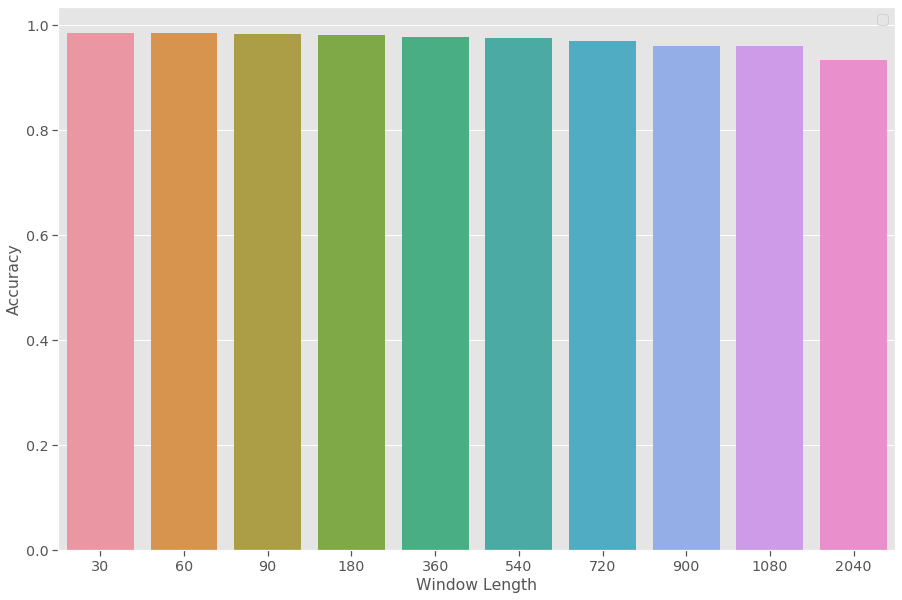

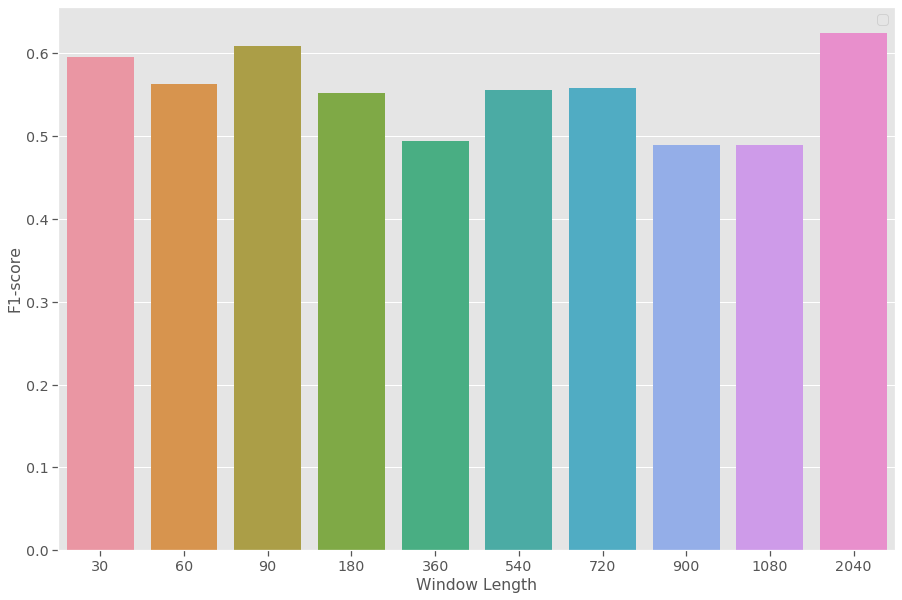

fridge - 7 (taxa=`2`, janela=`1080`)


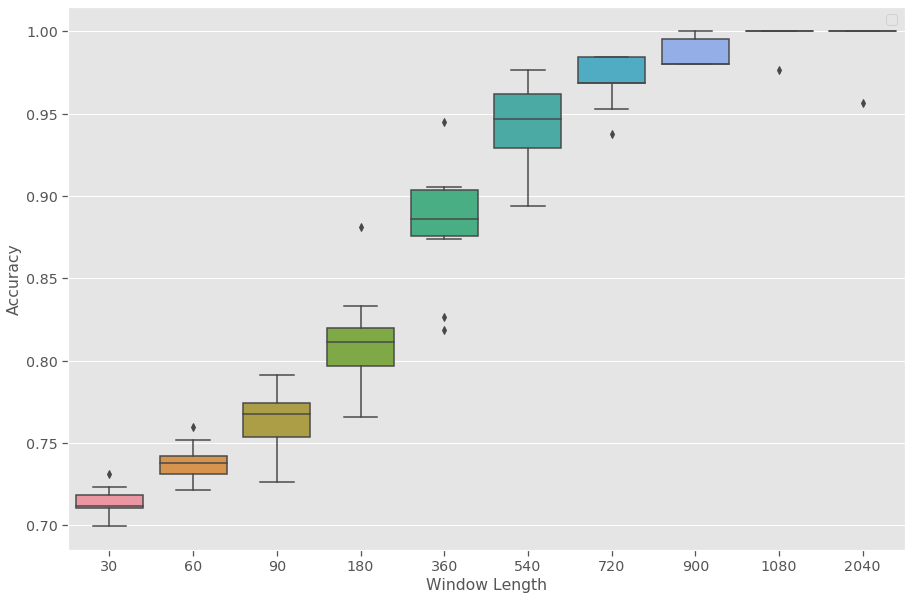

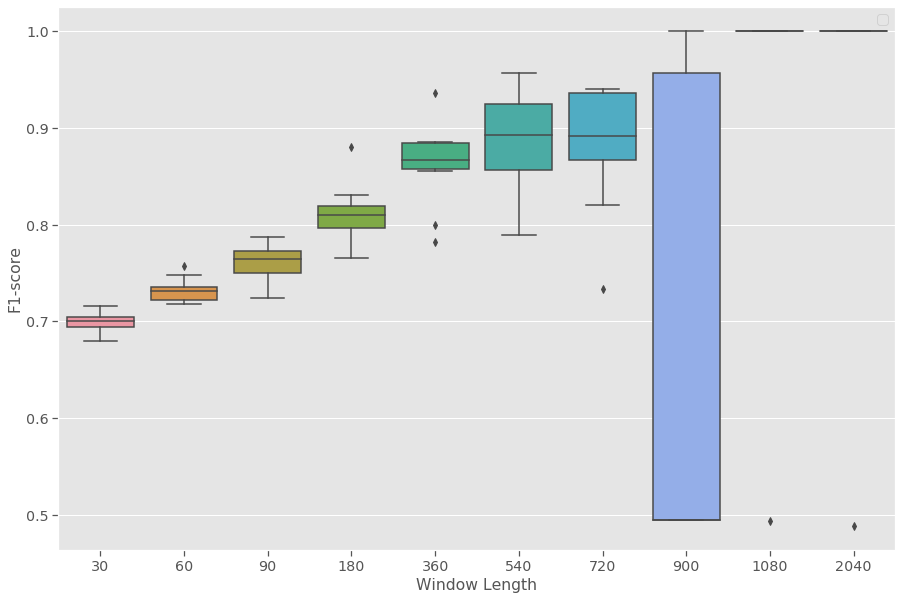

fridge - 7 (taxa=`2`, janela=`1080`)


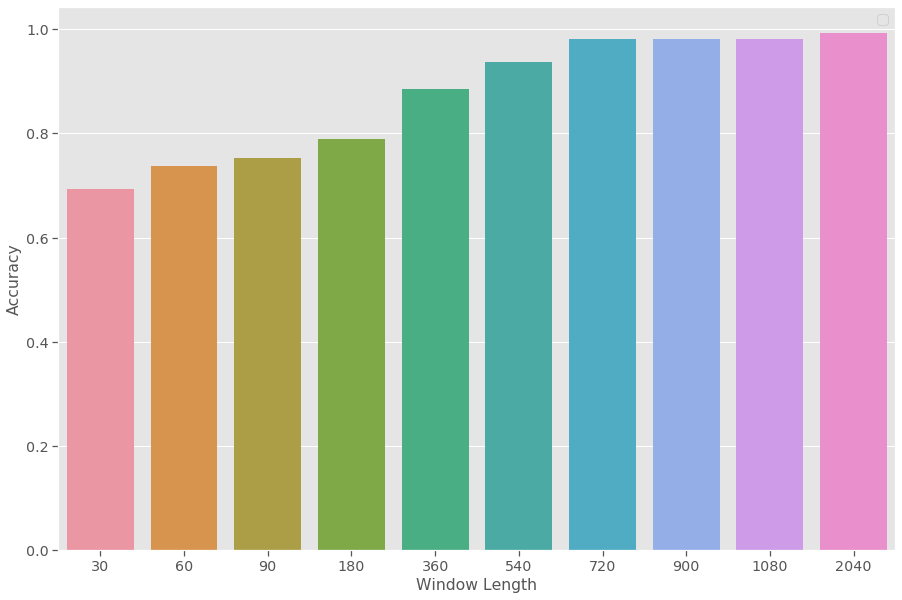

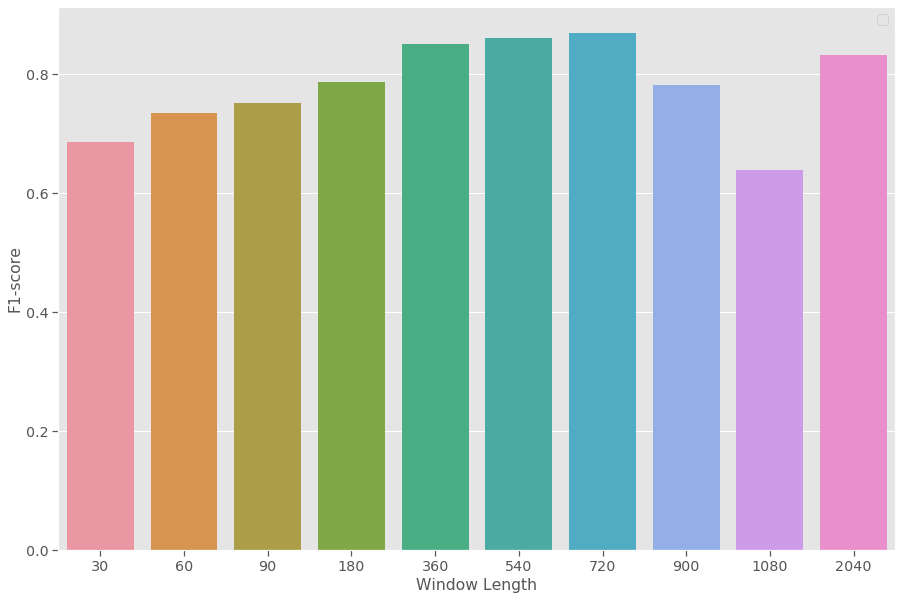

microwave - 16 (taxa=`2`, janela=`900`)


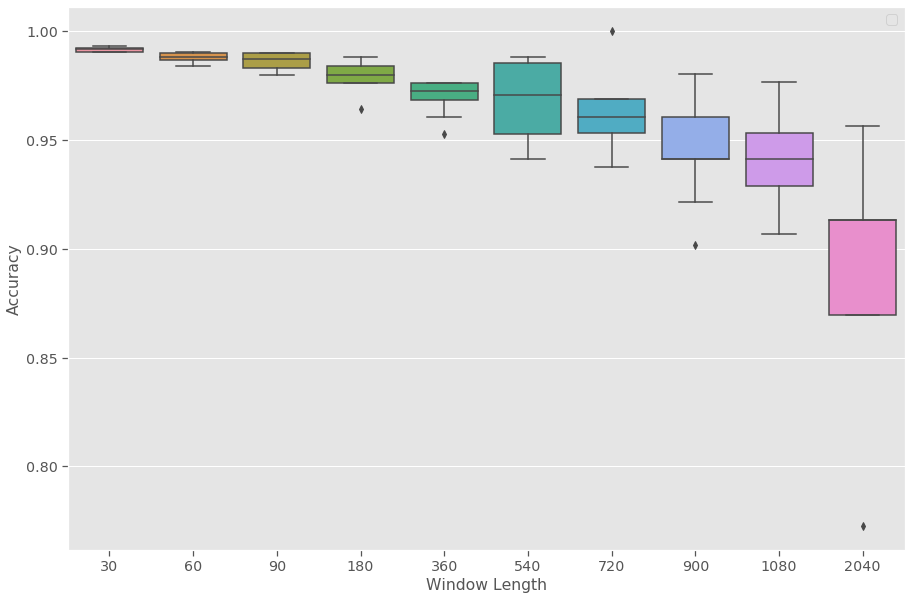

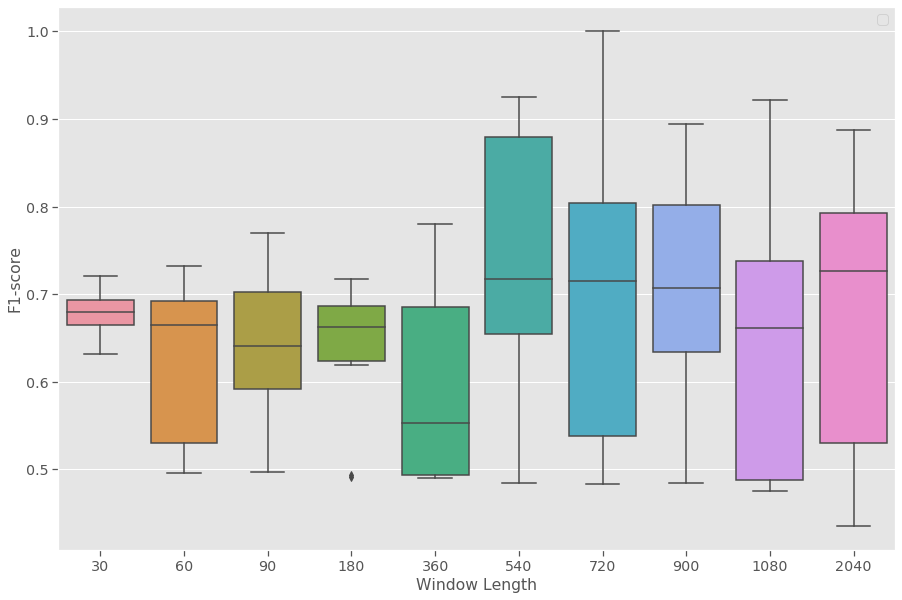

microwave - 16 (taxa=`2`, janela=`900`)


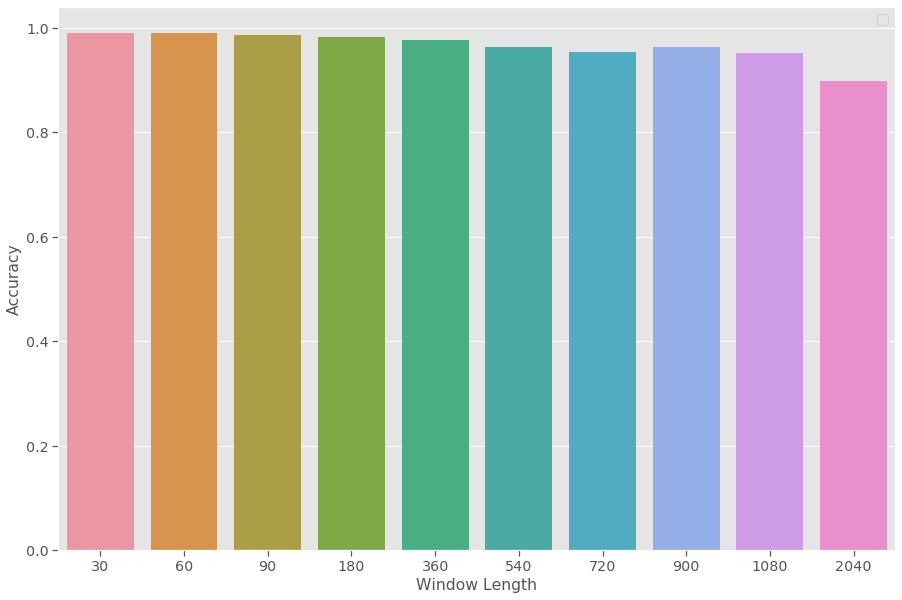

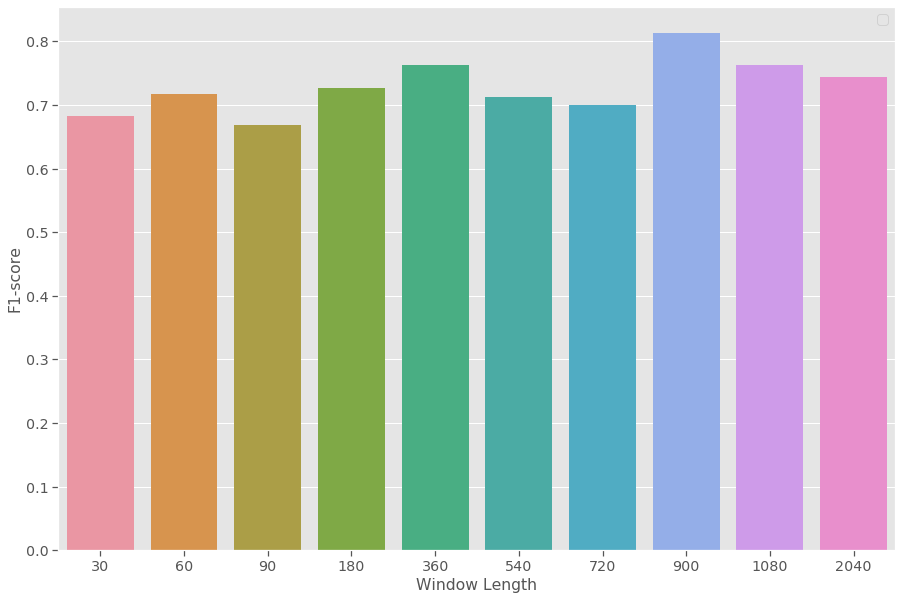

washer_dryer - 13 (taxa=`2`, janela=`60`)


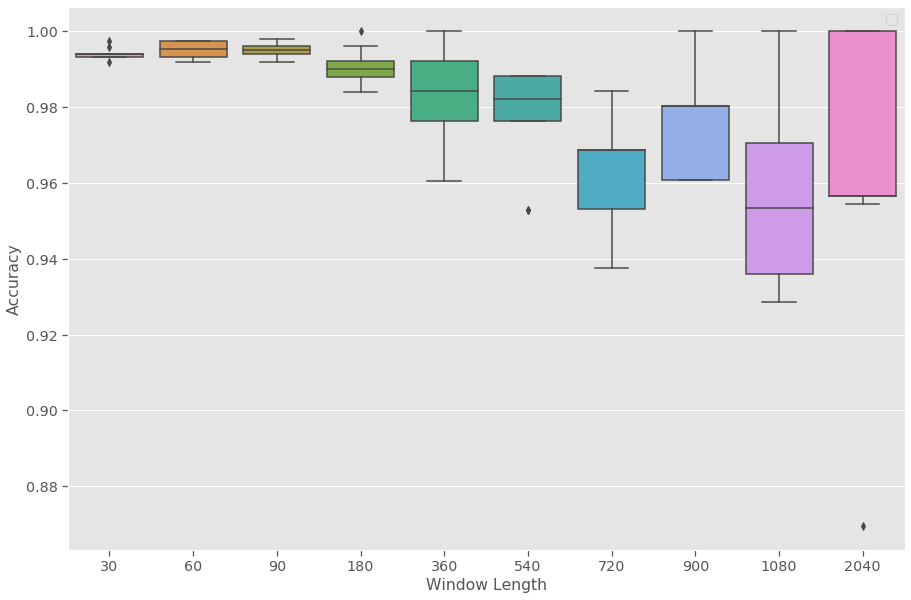

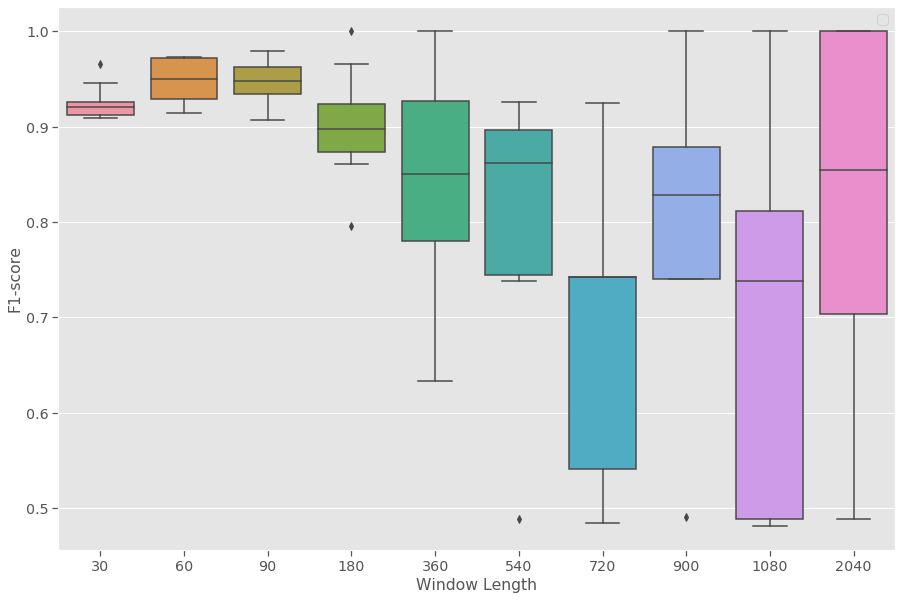

washer_dryer - 13 (taxa=`2`, janela=`60`)


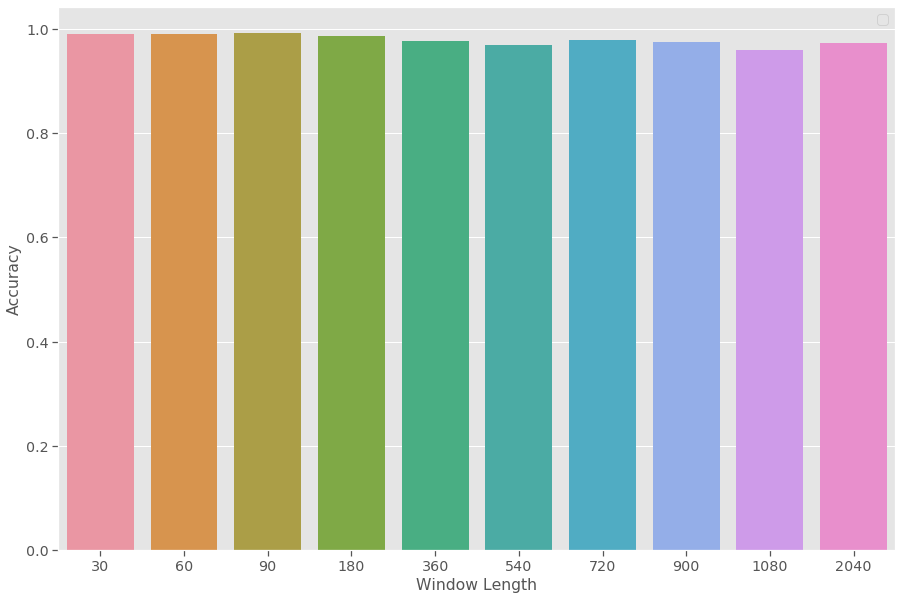

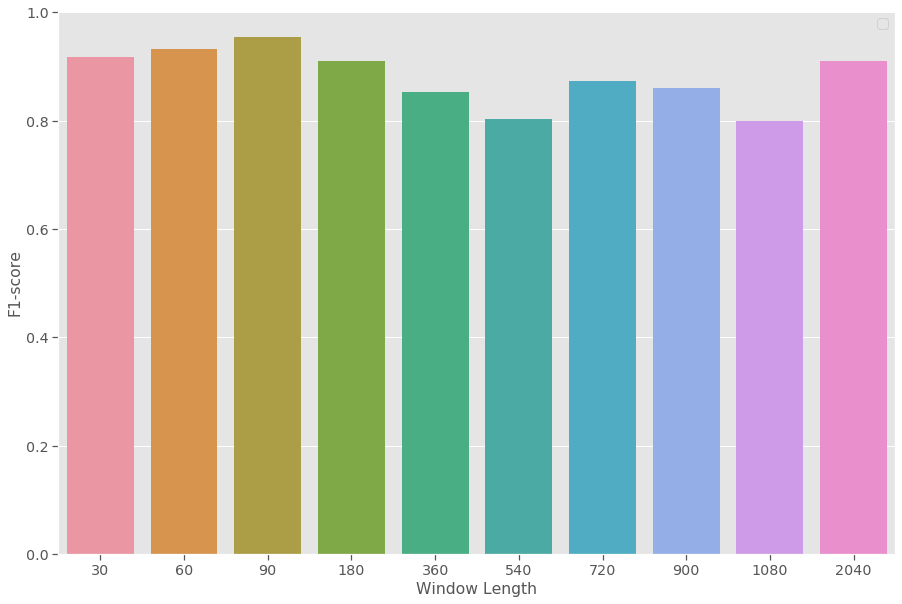

washer_dryer - 14 (taxa=`3`, janela=`360`)


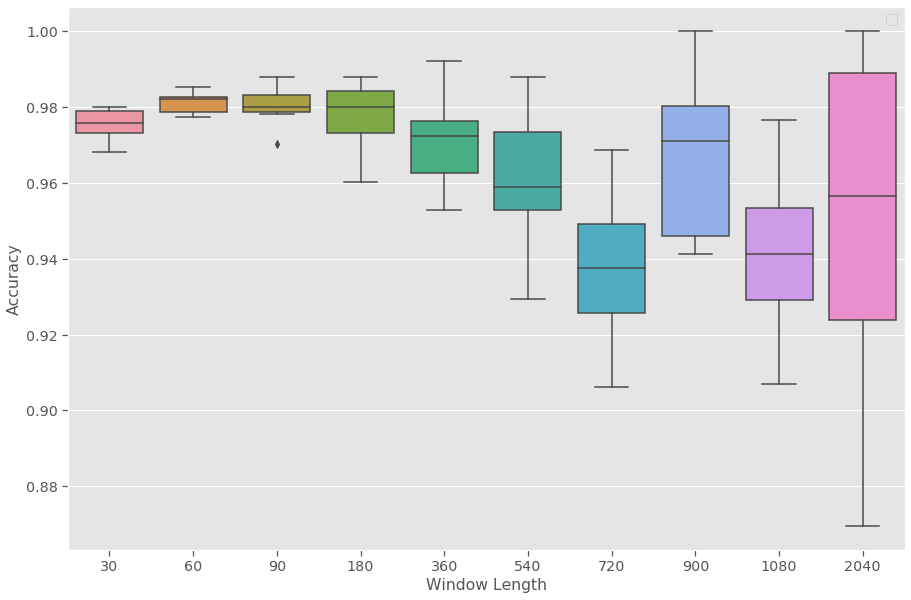

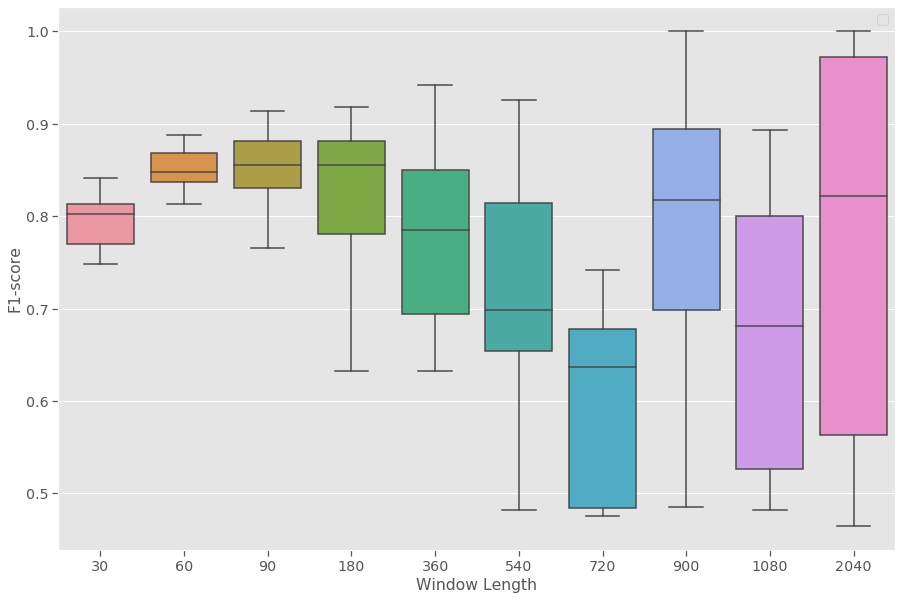

washer_dryer - 14 (taxa=`3`, janela=`360`)


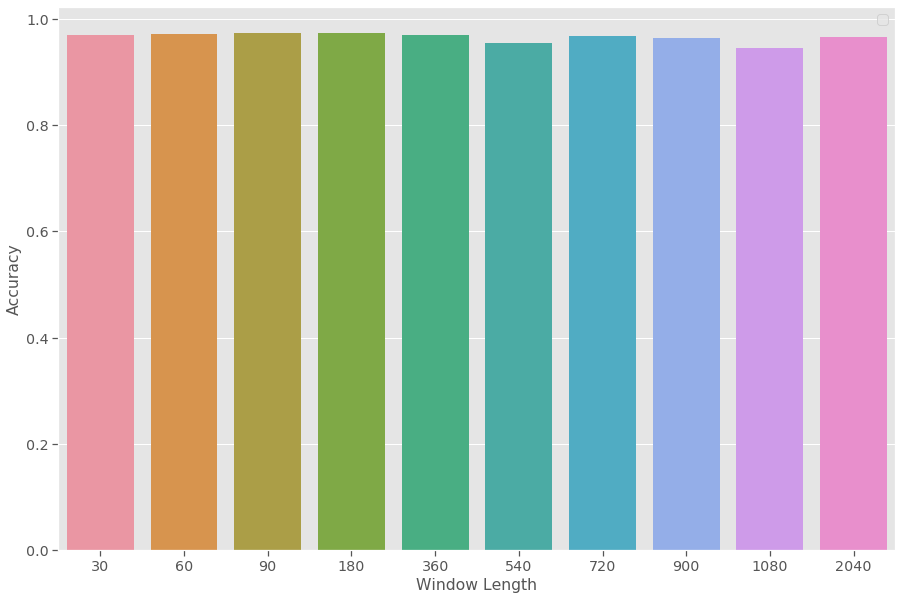

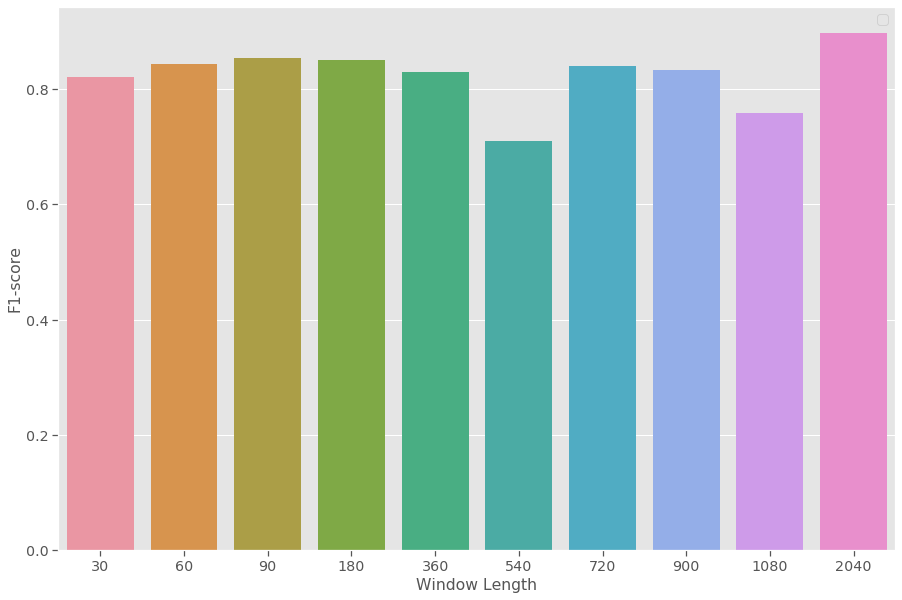

In [26]:
# Lendo resultados
df_resultados_janelas = pd.read_excel(
    os.path.join(caminho_dados_notebook, "df_resultados_janelas.xlsx"), 
    engine='openpyxl'
)

for a in df_resultados_janelas['appliance'].unique():
    
    # Dados base do aparelho
    config_aparelho = df_melhores_taxas_janelas[
            df_melhores_taxas_janelas["carga"]==a
        ].to_dict("records")[0]
    
    # fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    for i, b in enumerate(['treino','teste']):
        
        print(f"{a} (taxa=`{config_aparelho['taxa_amostragem']}`, janela=`{config_aparelho['janela']}`)")
        
        
        
        df_ = df_resultados_janelas.query(f"appliance == '{a}' and base == '{b}'").reset_index()

        if b == 'treino':
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.boxplot(x="window_length", y="acc", #hue="window_length", 
                        data=df_, 
                        ax=ax);
            ax.set(xlabel='Window Length', ylabel='Accuracy')#, title=f'Accuracy (base de {b})')
            ax.legend([])
            plt.show()
            fig.savefig(
                os.path.join(
                    caminho_imagens_notebook,
                    f'4_janelas_{a}_acuracia_{b}.png', 
                ),
                format='png', 
                dpi=300,
                bbox_inches='tight', 
                pad_inches=0
            )
            
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.boxplot(x="window_length", y="f1", #hue="window_length", 
                        data=df_, 
                        ax=ax);
            ax.set(xlabel='Window Length', ylabel='F1-score')
            ax.legend([])
            plt.show()
            fig.savefig(
                os.path.join(
                    caminho_imagens_notebook,
                    f'4_janelas_{a}_f1_{b}.png', 
                ),
                format='png', 
                dpi=300,
                bbox_inches='tight', 
                pad_inches=0
            )
        else:
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.barplot(x="window_length", y="acc", #hue="window_length", 
                        data=df_, 
                        ax=ax);
            ax.set(xlabel='Window Length', ylabel='Accuracy')
            ax.legend([])
            plt.show()
            fig.savefig(
                os.path.join(
                    caminho_imagens_notebook,
                    f'4_janelas_{a}_acuracia_{b}.png', 
                ),
                format='png', 
                dpi=300,
                bbox_inches='tight', 
                pad_inches=0
            )
            
            fig, ax = plt.subplots(figsize=(15, 10))
            sns.barplot(x="window_length", y="f1", #hue="window_length", 
                        data=df_, 
                        ax=ax);
            ax.set(xlabel='Window Length', ylabel='F1-score')
            ax.legend([])
            plt.show()
            fig.savefig(
                os.path.join(
                    caminho_imagens_notebook,
                    f'4_janelas_{a}_f1_{b}.png', 
                ),
                format='png', 
                dpi=300,
                bbox_inches='tight', 
                pad_inches=0
            )
        # axes[0][i].set(xlabel='Window Length', ylabel='Accuracy', title=f'Accuracy (base de {b})')
        # axes[1][i].set(xlabel='Window Length', ylabel='F1-score', title=f'F1-Score (base de {b})')
        
        # axes[0][i].legend([])
        # axes[1][i].legend([])
        
        # plt.suptitle(f"{a} (taxa=`{config_aparelho['taxa_amostragem']}`, janela=`{config_aparelho['janela']}`)", size=18);
    
    # plt.show();
    

## Aparelhos complexos (EM DESENVOLVIMENTO
---
Divididos em 3 categorias: longo tempo de transitório de ativação / alta flutuação de operação / aparelhos com sobreposição de transitórios

## Outras propostas (EM DESENVOLVIMENTO)

### Separabilidade DLAFE

In [ ]:
# https://towardsdatascience.com/dimensionality-reduction-in-hyperspectral-images-using-python-611b40b6accc

In [ ]:
recurrence_plots = []
dlafe_vectors = []
labels_status = []
labels_appliance = []

for rotulo_aparelho in df_melhores_taxas_janelas.loc[
    df_melhores_taxas_janelas["carga"].isin(
        ['dish_washer - 9','fridge - 7','microwave - 16',
        'washer_dryer - 13', 'washer_dryer - 14'
        ]),
    : ]["carga"].values:
    
    
    print(f"* Aparelho {rotulo_aparelho.upper()}:")
    print()
    
    # Informacoes da carga selecionada
    CARGA = rotulo_aparelho.split(" - ")[0]
    INSTANCIA = int(rotulo_aparelho.split(" - ")[1])

    config_aparelho = df_melhores_taxas_janelas[
        df_melhores_taxas_janelas["carga"]==rotulo_aparelho
    ].to_dict("records")[0]
    TAMANHO_JANELA = config_aparelho["janela"]
    TAXA = config_aparelho["taxa_amostragem"]
    CONFIG_RP_APARELHO = PARAMETROS_RP
    
    # Percorrer instancias do aparelho na residencia
#     for INSTANCIA in instancia_aparelho_residencia(CARGA, RESIDENCIA, base = redd):
        
    # Extrair series divididas em janelas para cada medidor
    print("   - Carregando dados (taxa={:.0f}, janela={:.0f})...".format(
        TAXA, TAMANHO_JANELA
    ))
    X_rp, y = carregar_dados_aparelho(
        janelas=janelas,
        instancia=INSTANCIA,
        aparelho=CARGA,
        tamanho_janela=TAMANHO_JANELA,
        taxa=TAXA,
        eliminar_janelas_vazias=True
    )
    print()

    print("   - Detalhes da amostragem (lotes):")
    print("   ---")
    for item in Counter(y).items():
        print(f"      - Classe `{item[0]}`: {item[1]} amostras ({round(item[1]/len(y)*100,1)}%)" )
    print()

    print("* Convertendo séries para RPs...")
    #rqa.extend( preparar_amostras(X, y, rotulo_aparelho) )
    X_rp, y = preparar_amostras(
        X_rp, y, 
        params_rp=PARAMETROS_RP,
        tam_imagem=TAMANHO_IMAGEM,
        normalizar=False # config. estudo 17 = False
    )
    #print(X.shape)

    # Extrair atributos usando Deep/Tranfer Learning
    X_dlafe = extrair_atributos_dl(
        X_rp, 
        modelo=modelo_extrator,
        preprocessamento=preprocess_extrator
    )
    
    recurrence_plots.append(X_rp)
    dlafe_vectors.append(X_dlafe)
    labels_status.append(y)
    labels_appliance.append([rotulo_aparelho for _ in range(len(y))])

In [ ]:
recurrence_plots = np.concatenate(recurrence_plots)
dlafe_vectors = np.concatenate(dlafe_vectors)
labels_status = np.concatenate(labels_status, axis=0)
labels_appliance = np.concatenate(labels_appliance, axis=0)

In [ ]:
import plotly.express as px
import seaborn  as sns
from sklearn.manifold import TSNE

In [ ]:
rp_tsne = TSNE(n_components=3).fit_transform(
    recurrence_plots[:,:,:,0].reshape(-1, TAMANHO_IMAGEM[0]*TAMANHO_IMAGEM[1])
)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=rp_tsne[:,0], y=rp_tsne[:,1],
    hue=labels_appliance,
    legend="full",
    alpha=0.3
)

In [ ]:
cdict = {'dish_washer - 9': 'green','fridge - 7':'blue','microwave - 16':'red',
        'washer_dryer - 13':'gray', 'washer_dryer - 14':'black'}

fig = px.scatter_3d(
    x=rp_tsne[:,0], 
    y=rp_tsne[:,1], 
    z=rp_tsne[:,2],
    color=labels_appliance
)
fig.show()

In [ ]:
dlafe_tsne = TSNE(n_components=3,n_iter=10000,random_state=SEED).fit_transform(dlafe_vectors)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=dlafe_tsne[:,0], y=dlafe_tsne[:,1],
    hue=labels_appliance,
    legend="full",
    alpha=0.3
)

In [ ]:
cdict = {'dish_washer - 9': 'green','fridge - 7':'blue','microwave - 16':'red',
        'washer_dryer - 13':'gray', 'washer_dryer - 14':'black'}

fig = px.scatter_3d(
    x=dlafe_tsne[:,0], 
    y=dlafe_tsne[:,1], 
    z=dlafe_tsne[:,2],
    color=labels_appliance
)
fig.show()

### Tentativas de Melhoria
---

CLF / Acc. / F1-Score <br>
Dishwasher      SVM  98.0  64.5<br>
Fridge          MLP 100.01 00.0<br>
Microwave       MLP  96.77 79.1 <br>
Washer Dryer 1  SVM  98.27 79.6<br>
Washer Dryer 2  SVM  98.27 79.6<br>

# Conclusões

...

# Fim.

In [13]:
%load_ext watermark

In [14]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Author: Diego Luiz Cavalca

Last updated: Tue May 04 2021 08:43:35Hora oficial do Brasil

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: a29eb3e98689f89f3597358428a2cab6bb3ab9b0

